<a id="0"></a> <br>
# Índice

1. [Data preparation](#1)
1. [Predicción citoquinas](#2)
    1. [IL-6](#3)
        1. [Red Neuronal](#9)
    1. [IL-8](#4)
        1. [Red Neuronal](#10)
    1. [TNF-$\alpha$](#5)
        1. [Red Neuronal](#11)
    1. [IL-1$\beta$](#6)
        1. [Red Neuronal](#12)
    1. [Pruebas Entrenamiento](#13)
1. [Lab-test](#7)
1. [Comorbilidades](#8)
1. [Relaciones citoquinas alteradas-severidad](#14)
1. [PCR-COVID](#15)
1. [Estimación de parámetros](#16)
1. [Validación cruzada: Modelo de predicción](#17)

<a id="1"></a>
# 1. Data preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import mysql.connector
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Conexión a la base de datos
cnx = mysql.connector.connect(user='root', password='Supersayan0,07',
                              host='localhost', database='sdy1662')

# Consulta SQL para obtener la tabla
query = "SELECT * FROM cito_val_no_filtr_2"

# Lectura de la tabla en un DataFrame de Pandas
df = pd.read_sql(query, cnx)

# Cierre de la conexión
cnx.close()
df_1 = df[df['study_time_collected'] != 999]
df_1.head()

,subject_accession,gender,Age,study_time_collected,name,IL6,IL8,TNFA,IL1B
0,SUB210882,Female,80.0,0.627326,Original Cohort,659.0,126.0,18.0,2.8
1,SUB211535,Male,39.0,0.830949,Original Cohort,50.1,22.2,18.0,1.2
2,SUB212435,Female,38.0,3.575360,Original Cohort,778.3,47.0,18.0,0.2
3,SUB211932,Female,59.0,0.833333,Original Cohort,121.0,41.1,18.0,0.1
4,SUB211500,Male,58.0,1.446530,Original Cohort,13.8,23.3,18.0,0.1


In [2]:
#qué columnas tienen los datos
df_1.columns

Index(['subject_accession', 'gender', 'Age', 'study_time_collected', 'name',
       'IL6', 'IL8', 'TNFA', 'IL1B'],
      dtype='object')

In [3]:
#qué tamaño tienen los datos
df_1.shape

(2169, 9)

In [4]:
#hay valores nulos en los datos?
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2169 entries, 0 to 2339
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subject_accession     2169 non-null   object 
 1   gender                2169 non-null   object 
 2   Age                   2169 non-null   float64
 3   study_time_collected  2169 non-null   float64
 4   name                  2169 non-null   object 
 5   IL6                   2169 non-null   float64
 6   IL8                   2163 non-null   float64
 7   TNFA                  2165 non-null   float64
 8   IL1B                  2161 non-null   float64
dtypes: float64(6), object(3)
memory usage: 169.5+ KB


In [5]:
#cómo se distribuyen las variables numéricas
df_1.describe()

,Age,study_time_collected,IL6,IL8,TNFA,IL1B
count,2169.000000,2169.000000,2169.000000,2163.000000,2165.000000,2161.000000
mean,60.022130,5.191399,1119.423882,133.273601,28.520647,1.184405
std,19.059953,13.182633,18510.211396,1133.625002,54.641406,9.063230
min,0.000000,0.000000,0.100000,0.100000,0.100000,0.100000
25%,50.000000,0.621528,20.700000,21.700000,13.800000,0.100000
50%,63.000000,0.961806,60.400000,40.200000,20.200000,0.400000
75%,73.000000,3.037500,138.000000,74.700000,30.100000,0.800000
max,89.000000,185.101000,674776.400000,36988.000000,1364.000000,380.000000


In [6]:
df_1.describe(include='object')

,subject_accession,gender,name
count,2169,2169,2169
unique,2169,2,2
top,SUB210882,Male,Original Cohort
freq,1,1248,1313


In [7]:
df.groupby(['name']).count()['subject_accession']

name
Original Cohort      1484
Validation Cohort     856
Name: subject_accession, dtype: int64

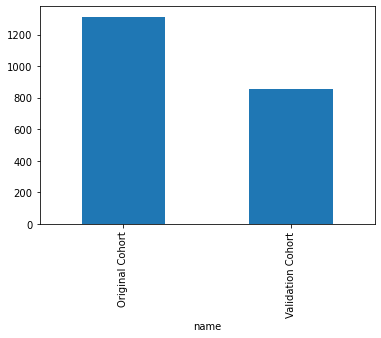

In [8]:
grouped_name=df_1.groupby(['name']).count()['subject_accession']
(grouped_name.plot.bar())
plt.show()

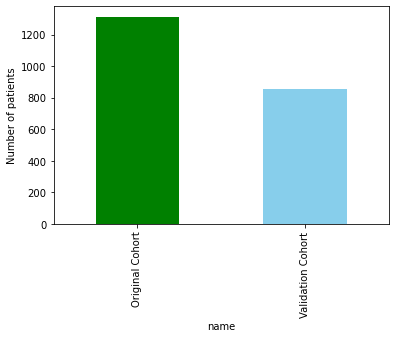

In [9]:
import matplotlib.pyplot as plt

grouped_name = df_1.groupby(['name']).count()['subject_accession']

# Generamos una lista de colores del mismo tamaño que los datos.
colors = ['green', 'skyblue']

grouped_name.plot.bar(color=colors)

plt.ylabel('Number of patients')

plt.show()

In [10]:
df_1.groupby(['gender']).count()['subject_accession']

gender
Female     921
Male      1248
Name: subject_accession, dtype: int64

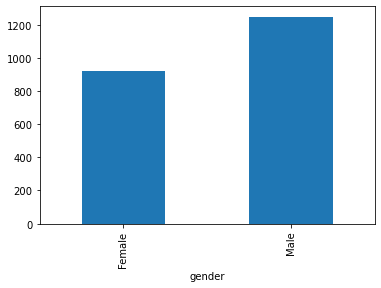

In [11]:
grouped_sex = df_1.groupby(['gender']).count()['subject_accession']
(grouped_sex.plot.bar())
plt.show()

In [12]:
df_1.groupby(['name', 'gender']).count()['subject_accession']

name               gender
Original Cohort    Female    530
                   Male      783
Validation Cohort  Female    391
                   Male      465
Name: subject_accession, dtype: int64

C:\Users\quik9\Anaconda3\envs\bdbiotec\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


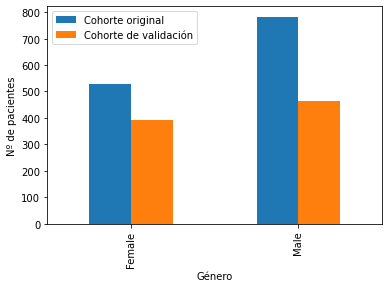

In [13]:
df_1['gender'] = df_1['gender'].replace({'male': 'masculino', 'female': 'femenino'})
grouped_sex = df_1.groupby(['name', 'gender']).count()['subject_accession']
ax = grouped_sex.unstack(level=0).plot.bar()

# Cambiar el nombre de los ejes
plt.xlabel('Género')
plt.ylabel('Nº de pacientes')

# Cambiar las leyendas
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Cohorte original', 'Cohorte de validación'])

plt.show()

In [14]:
df_1[['IL6', 'IL8', 'TNFA', 'IL1B']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2169 entries, 0 to 2339
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IL6     2169 non-null   float64
 1   IL8     2163 non-null   float64
 2   TNFA    2165 non-null   float64
 3   IL1B    2161 non-null   float64
dtypes: float64(4)
memory usage: 84.7 KB


In [15]:
df_1_1 = df_1[['IL8', 'TNFA', 'IL1B']]
columnas = [col for col in df_1.columns if col not in ['gender','name']]
for col in df_1_1.columns:
    result = (df_1[df_1[col].isna()]).groupby(['gender', 'name']).count()['subject_accession'].unstack(level=0)
    print(f"Citoquina: {col}")
    print(result)

Citoquina: IL8
gender             Male
name                   
Original Cohort       5
Validation Cohort     1
Citoquina: TNFA
gender           Male
name                 
Original Cohort     4
Citoquina: IL1B
gender           Female  Male
name                         
Original Cohort       3     5


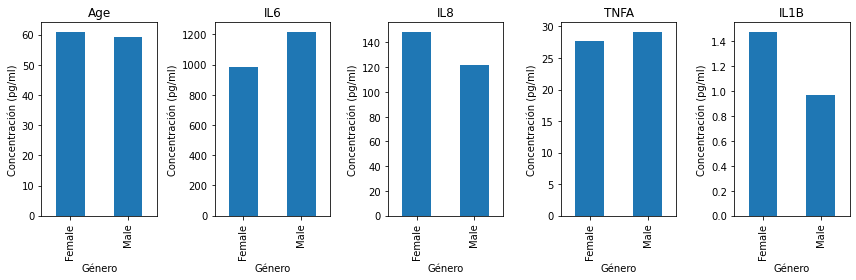

In [16]:
# Agrupar los datos por sexo y calcular la media de cada columna para hombres y mujeres
df_1_1 = df_1.drop('study_time_collected', axis = 1)
df_1_1 = df_1_1.groupby('gender').mean()

# Crear una figura con cuatro gráficos
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))

# Generar los gráficos de barras para cada columna
for i, columna in enumerate(df_1_1.columns):
    df_1_1[columna].plot(kind='bar', ax=axes[i])
    axes[i].set_title(columna)

    # Cambiar el nombre de los ejes
    axes[i].set_xlabel('Género')
    axes[i].set_ylabel('Concentración (pg/ml)')

# Ajustar el espaciado entre los gráficos y mostrar la figura
fig.tight_layout()
plt.show()

In [17]:
df_1_1.median()

Age       60.151805
IL6     1101.775237
IL8      135.281141
TNFA      28.403832
IL1B       1.222944
dtype: float64

In [18]:
df_1 = df_1.dropna(subset=['IL8','TNFA','IL1B'])
df_1

,subject_accession,gender,Age,study_time_collected,name,IL6,IL8,TNFA,IL1B
0,SUB210882,Female,80.0,0.627326,Original Cohort,659.0,126.0,18.0,2.8
1,SUB211535,Male,39.0,0.830949,Original Cohort,50.1,22.2,18.0,1.2
2,SUB212435,Female,38.0,3.575360,Original Cohort,778.3,47.0,18.0,0.2
3,SUB211932,Female,59.0,0.833333,Original Cohort,121.0,41.1,18.0,0.1
4,SUB211500,Male,58.0,1.446530,Original Cohort,13.8,23.3,18.0,0.1
...,...,...,...,...,...,...,...,...,...
2334,SUB212739,Male,42.0,0.000000,Original Cohort,158.0,20.9,31.3,0.4
2335,SUB210920,Female,75.0,3.039580,Original Cohort,9.3,34.5,31.3,0.3
2337,SUB211023,Female,51.0,0.236771,Original Cohort,1113.0,263.0,31.2,4.3
2338,SUB212480,Male,75.0,1.052080,Original Cohort,53.5,21.0,31.2,0.6


<a id="2"></a>
## 2. Predicción con cada una de las citoquinas por separado
[back to top](#0)

<a id="3"></a>
### Clasificación IL-6
[back to top](#0)

In [19]:
df_IL6 = df_1[['subject_accession','gender','study_time_collected','name','IL6']]
df_IL6['flag'] = np.where(df_IL6['IL6'] > 70, 1, 0)
df_IL6

C:\Users\quik9\Anaconda3\envs\bdbiotec\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,subject_accession,gender,study_time_collected,name,IL6,flag
0,SUB210882,Female,0.627326,Original Cohort,659.0,1
1,SUB211535,Male,0.830949,Original Cohort,50.1,0
2,SUB212435,Female,3.575360,Original Cohort,778.3,1
3,SUB211932,Female,0.833333,Original Cohort,121.0,1
4,SUB211500,Male,1.446530,Original Cohort,13.8,0
...,...,...,...,...,...,...
2334,SUB212739,Male,0.000000,Original Cohort,158.0,1
2335,SUB210920,Female,3.039580,Original Cohort,9.3,0
2337,SUB211023,Female,0.236771,Original Cohort,1113.0,1
2338,SUB212480,Male,1.052080,Original Cohort,53.5,0


In [20]:
X_IL6 = df_IL6[['IL6']].values
y_IL6 = df_IL6['flag'].values

In [21]:
from sklearn.model_selection import train_test_split
X_train_IL6, X_test_IL6, y_train_IL6, y_test_IL6 =train_test_split(X_IL6, y_IL6, test_size=0.25, random_state=123, stratify=y_IL6)

In [22]:
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train_IL6, X_test_IL6, y_train_IL6, y_test_IL6)
print(models)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 17.33it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
AdaBoostClassifier                 1.00               1.00     1.00      1.00   
KNeighborsClassifier               1.00               1.00     1.00      1.00   
XGBClassifier                      1.00               1.00     1.00      1.00   
RandomForestClassifier             1.00               1.00     1.00      1.00   
DecisionTreeClassifier             1.00               1.00     1.00      1.00   
BaggingClassifier                  1.00               1.00     1.00      1.00   
ExtraTreeClassifier                1.00               1.00     1.00      1.00   
ExtraTreesClassifier               1.00               1.00     1.00      1.00   
LGBMClassifier                     1.00               1.00     1.00      1.00   
PassiveAggressiveClassifier        0.95               0.95     0.95      0.95   
NuSVC                       

In [23]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
clf_IL6 = DecisionTreeClassifier(criterion="entropy",random_state=0)
clf_IL6.fit(X_train_IL6, y_train_IL6)
y_pred = clf_IL6.predict(X_test_IL6)
print('Exactitud - Accuracy: %.3f' % accuracy_score(y_true=y_test_IL6, y_pred=y_pred))

Exactitud - Accuracy: 1.000


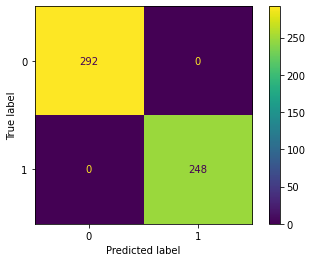

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=y_test_IL6, y_pred=y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [25]:
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from IPython import display

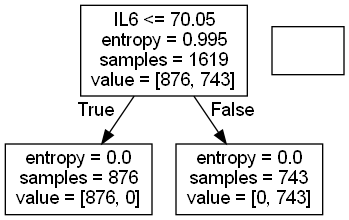

In [26]:
dot_data = export_graphviz(clf_IL6,feature_names=['IL6'])
graph = graph_from_dot_data(dot_data)
graph.write_png('./images/decision_tree.png')
display.Image("./images/decision_tree.png", width="700")

In [27]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, criterion='gini')
model.fit(X_train_IL6, y_train_IL6)
y_pred = model.predict(X_test_IL6)

In [28]:
from sklearn.metrics import accuracy_score
print('Exactitud - Accuracy: %.3f' % accuracy_score(y_true=y_test_IL6, y_pred=y_pred))

Exactitud - Accuracy: 1.000


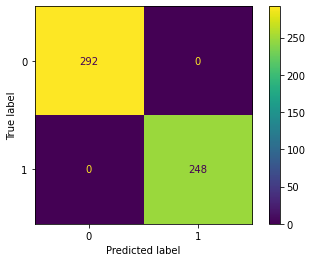

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test_IL6, y_test_IL6)

<a id="9"></a>
### Red Neuronal IL-6
[back to top](#0)

In [30]:
from IPython.display import HTML
from tabulate import tabulate

In [31]:
i=1
o=2
h=2*(i+o)/3
int(h), h

(2, 2.0)

In [32]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
df_IL6[['IL6']] = sc.fit_transform(df_IL6[['IL6']])
df_IL6.head()

,subject_accession,gender,study_time_collected,name,IL6,flag
0,SUB210882,Female,0.63,Original Cohort,-0.01,1
1,SUB211535,Male,0.83,Original Cohort,-0.07,0
2,SUB212435,Female,3.58,Original Cohort,-0.00,1
3,SUB211932,Female,0.83,Original Cohort,-0.06,1
4,SUB211500,Male,1.45,Original Cohort,-0.07,0


In [33]:
X_IL6 = df_IL6[['IL6']].values
y_IL6 = df_IL6['flag'].values

In [34]:
from sklearn.model_selection import train_test_split
X_train_IL6, X_test_IL6, y_train_IL6, y_test_IL6 =train_test_split(X_IL6, y_IL6, test_size=0.3, random_state=123, stratify=y_IL6)

## Importación de la clase del perceptrón multicapa
from sklearn.neural_network import MLPClassifier
## Inicialización y creación del objeto clasificador
best_score = 0
mejor_neuronas= 0
neuronas = []
score_train = []
score_test = []
columnas = ['nº neuronas', 'train score', 'test score']
for i in range(4,100):
    mlp = MLPClassifier(hidden_layer_sizes=(i, i-3), max_iter=3000,activation = 'relu',solver='sgd',random_state=1, learning_rate='adaptive',learning_rate_init=0.015)
    mlp.fit(X_train_IL6, y_train_IL6)
    score_train.append(mlp.score(X_train_IL6, y_train_IL6))
    score_test.append(mlp.score(X_test_IL6, y_test_IL6))
    neuronas.append(i)
    if mlp.score(X_test_IL6, y_test_IL6) > best_score:
        best_score = mlp.score(X_test_IL6, y_test_IL6)
        mejor_neuronas = i
df = pd.DataFrame(list(zip(neuronas, score_train, score_test)),
               columns = columnas)
df = df.set_index(columnas[0])
print (tabulate(df,headers=columnas, tablefmt='psql'))
HTML("<b>El mejor score en el test se consigue con {} neuronas, con una exactitud del {:.3f}</b>".format(mejor_neuronas,best_score))

In [35]:
len(X_train_IL6[0]), np.unique(y_train_IL6), len(X_train_IL6), len(y_train_IL6), len(X_test_IL6), len(y_test_IL6)

(1, array([0, 1]), 1511, 1511, 648, 648)

In [36]:
run 05.0_RNN_Redes_Neuronales_Utilidades.ipynb

<Figure size 432x288 with 0 Axes>

In [37]:
capasOcultas=[9]
print(capasOcultas)
nn_IL6 = NeuralNetwork(eta=0.025, epocas=9000, hiddenLayers=capasOcultas, minibatch_size=100, shuffle=False, seed=1)
nn_IL6.fit(X_train_IL6, y_train_IL6)

[9]
Epoca =====> 1 Coste ====> 3.750438986225635
Epoca =====> 1001 Coste ====> 1.9233624369886566
Epoca =====> 2001 Coste ====> 1.2747486154185204
Epoca =====> 3001 Coste ====> 1.3024131896445463
Epoca =====> 4001 Coste ====> 0.6148667776604597
Epoca =====> 5001 Coste ====> 0.6574991438687772
Epoca =====> 6001 Coste ====> 0.5732764384613271
Epoca =====> 7001 Coste ====> 0.5331346288323354
Epoca =====> 8001 Coste ====> 0.5076951815336013
Epoca =====> 9000 Coste ====> 0.4865024005371152


In [38]:
y_pred_train= nn_IL6.predict(X_train_IL6)

In [39]:
from sklearn.metrics import accuracy_score
print('Exactitud - Accuracy: %.4f' % float(100.0*accuracy_score(y_true=y_train_IL6, y_pred=y_pred_train)))

Exactitud - Accuracy: 89.8743


In [40]:
from sklearn.metrics import confusion_matrix
cm_train = confusion_matrix(y_train_IL6, y_pred_train)
cm_train

array([[664, 153],
       [  0, 694]], dtype=int64)

In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_train_IL6, y_pred=y_pred_train, target_names=['Normal', 'Alterado']))

              precision    recall  f1-score   support

      Normal       1.00      0.81      0.90       817
    Alterado       0.82      1.00      0.90       694

    accuracy                           0.90      1511
   macro avg       0.91      0.91      0.90      1511
weighted avg       0.92      0.90      0.90      1511



In [42]:
y_pred_train= nn_IL6.predict(X_test_IL6)

In [43]:
from sklearn.metrics import accuracy_score
print('Exactitud - Accuracy: %.4f' % float(100.0*accuracy_score(y_true=y_test_IL6, y_pred=y_pred_train)))

Exactitud - Accuracy: 90.4321


In [44]:
from sklearn.metrics import confusion_matrix
cm_train = confusion_matrix(y_test_IL6, y_pred_train)
cm_train

array([[289,  62],
       [  0, 297]], dtype=int64)

In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_test_IL6, y_pred=y_pred_train, target_names=['Normal', 'Alterado']))

              precision    recall  f1-score   support

      Normal       1.00      0.82      0.90       351
    Alterado       0.83      1.00      0.91       297

    accuracy                           0.90       648
   macro avg       0.91      0.91      0.90       648
weighted avg       0.92      0.90      0.90       648



<a id="4"></a>
### Clasificación IL-8
[back to top](#0)

In [46]:
df_IL8 = df_1[['subject_accession','gender','study_time_collected','name','IL8']]
df_IL8['flag'] = np.where(df_IL8['IL8'] > 50, 1, 0)
df_IL8

,subject_accession,gender,study_time_collected,name,IL8,flag
0,SUB210882,Female,0.63,Original Cohort,126.00,1
1,SUB211535,Male,0.83,Original Cohort,22.20,0
2,SUB212435,Female,3.58,Original Cohort,47.00,0
3,SUB211932,Female,0.83,Original Cohort,41.10,0
4,SUB211500,Male,1.45,Original Cohort,23.30,0
...,...,...,...,...,...,...
2334,SUB212739,Male,0.00,Original Cohort,20.90,0
2335,SUB210920,Female,3.04,Original Cohort,34.50,0
2337,SUB211023,Female,0.24,Original Cohort,263.00,1
2338,SUB212480,Male,1.05,Original Cohort,21.00,0


In [47]:
X_IL8 = df_IL8[['IL8']].values
y_IL8 = df_IL8['flag'].values

In [48]:
from sklearn.model_selection import train_test_split
X_train_IL8, X_test_IL8, y_train_IL8, y_test_IL8 =train_test_split(X_IL8, y_IL8, test_size=0.25, random_state=123, stratify=y_IL8)

In [49]:
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train_IL8, X_test_IL8, y_train_IL8, y_test_IL8)
print(models)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 21.23it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
AdaBoostClassifier                 1.00               1.00     1.00      1.00   
KNeighborsClassifier               1.00               1.00     1.00      1.00   
XGBClassifier                      1.00               1.00     1.00      1.00   
RandomForestClassifier             1.00               1.00     1.00      1.00   
DecisionTreeClassifier             1.00               1.00     1.00      1.00   
BaggingClassifier                  1.00               1.00     1.00      1.00   
ExtraTreeClassifier                1.00               1.00     1.00      1.00   
ExtraTreesClassifier               1.00               1.00     1.00      1.00   
LGBMClassifier                     1.00               1.00     1.00      1.00   
Perceptron                         0.97               0.98     0.98      0.97   
PassiveAggressiveClassifier 

In [50]:
clf_IL8 = DecisionTreeClassifier(criterion="entropy",random_state=0)
clf_IL8.fit(X_train_IL8, y_train_IL8)
y_pred = clf_IL8.predict(X_test_IL8)
print('Exactitud - Accuracy: %.3f' % accuracy_score(y_true=y_test_IL8, y_pred=y_pred))

Exactitud - Accuracy: 1.000


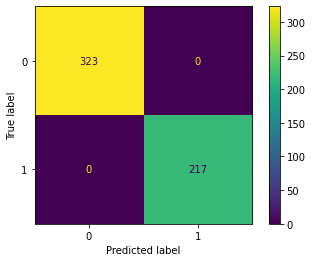

In [51]:
cm = confusion_matrix(y_true=y_test_IL8, y_pred=y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

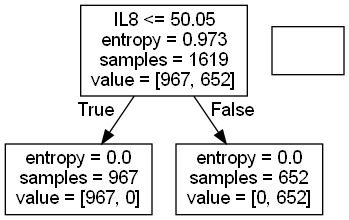

In [52]:
dot_data = export_graphviz(clf_IL8,feature_names=['IL8'])
graph = graph_from_dot_data(dot_data)
graph.write_png('./images/decision_tree_IL8.png')
display.Image("./images/decision_tree_IL8.png", width="700")

In [53]:
model_IL8 = RandomForestClassifier(n_estimators=100, criterion='gini')
model_IL8.fit(X_train_IL8, y_train_IL8)
y_pred = model_IL8.predict(X_test_IL8)

In [54]:
from sklearn.metrics import accuracy_score
print('Exactitud - Accuracy: %.3f' % accuracy_score(y_true=y_test_IL8, y_pred=y_pred))

Exactitud - Accuracy: 1.000


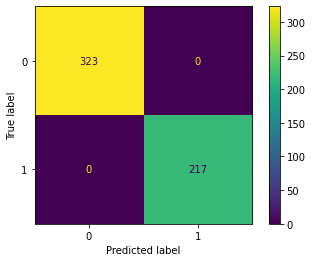

In [55]:
plot_confusion_matrix(model_IL8, X_test_IL8, y_test_IL8)

<a id="10"></a>
### Red Neuronal IL-8
[back to top](#0)

In [56]:
i=1
o=2
h=2*(i+o)/3
int(h), h

(2, 2.0)

In [57]:
sc = StandardScaler()
df_IL8[['IL8']] = sc.fit_transform(df_IL8[['IL8']])
df_IL8.head()

,subject_accession,gender,study_time_collected,name,IL8,flag
0,SUB210882,Female,0.63,Original Cohort,-0.01,1
1,SUB211535,Male,0.83,Original Cohort,-0.10,0
2,SUB212435,Female,3.58,Original Cohort,-0.08,0
3,SUB211932,Female,0.83,Original Cohort,-0.08,0
4,SUB211500,Male,1.45,Original Cohort,-0.10,0


In [58]:
X_IL8 = df_IL8[['IL8']].values
y_IL8 = df_IL8['flag'].values

In [59]:
from sklearn.model_selection import train_test_split
X_train_IL8, X_test_IL8, y_train_IL8, y_test_IL8 =train_test_split(X_IL8, y_IL8, test_size=0.25, random_state=123, stratify=y_IL8)

## Importación de la clase del perceptrón multicapa
from sklearn.neural_network import MLPClassifier
## Inicialización y creación del objeto clasificador
best_score = 0
mejor_neuronas= 0
neuronas = []
score_train = []
score_test = []
columnas = ['nº neuronas', 'train score', 'test score']
for i in range(4,100):
    mlp = MLPClassifier(hidden_layer_sizes=(i, i-3), max_iter=3000,activation = 'relu',solver='sgd',random_state=1, learning_rate='adaptive',learning_rate_init=0.015)
    mlp.fit(X_train_IL8, y_train_IL8)
    score_train.append(mlp.score(X_train_IL8, y_train_IL8))
    score_test.append(mlp.score(X_test_IL8, y_test_IL8))
    neuronas.append(i)
    if mlp.score(X_test_IL8, y_test_IL8) > best_score:
        best_score = mlp.score(X_test_IL8, y_test_IL8)
        mejor_neuronas = i
df = pd.DataFrame(list(zip(neuronas, score_train, score_test)),
               columns = columnas)
df = df.set_index(columnas[0])
print (tabulate(df,headers=columnas, tablefmt='psql'))
HTML("<b>El mejor score en el test se consigue con {} neuronas, con una exactitud del {:.3f}</b>".format(mejor_neuronas,best_score))

In [60]:
capasOcultas=[8]
print(capasOcultas)
nn_IL8 = NeuralNetwork(eta=0.025, epocas=9000, hiddenLayers=capasOcultas, minibatch_size=100, shuffle=False, seed=1)
nn_IL8.fit(X_train_IL8, y_train_IL8)

[8]
Epoca =====> 1 Coste ====> 3.874492808753425
Epoca =====> 1001 Coste ====> 0.20946816502417595
Epoca =====> 2001 Coste ====> 0.14132376522406961
Epoca =====> 3001 Coste ====> 0.1126408877171796
Epoca =====> 4001 Coste ====> 0.09626347834066738
Epoca =====> 5001 Coste ====> 0.08547296741844687
Epoca =====> 6001 Coste ====> 0.07775030040833948
Epoca =====> 7001 Coste ====> 0.07191646569883206
Epoca =====> 8001 Coste ====> 0.06733623977349118
Epoca =====> 9000 Coste ====> 0.06363472596797906


In [61]:
y_pred_train= nn_IL8.predict(X_train_IL8)

In [62]:
print('Exactitud - Accuracy: %.4f' % float(100.0*accuracy_score(y_true=y_train_IL8, y_pred=y_pred_train)))

Exactitud - Accuracy: 99.5676


In [63]:
from sklearn.metrics import confusion_matrix
cm_train = confusion_matrix(y_train_IL8, y_pred_train)
cm_train

array([[960,   7],
       [  0, 652]], dtype=int64)

In [64]:
print(classification_report(y_true=y_train_IL8, y_pred=y_pred_train, target_names=['Normal', 'Alterado']))

              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00       967
    Alterado       0.99      1.00      0.99       652

    accuracy                           1.00      1619
   macro avg       0.99      1.00      1.00      1619
weighted avg       1.00      1.00      1.00      1619



In [65]:
y_pred_train= nn_IL8.predict(X_test_IL8)

In [66]:
print('Exactitud - Accuracy: %.4f' % float(100.0*accuracy_score(y_true=y_test_IL8, y_pred=y_pred_train)))

Exactitud - Accuracy: 99.4444


In [67]:
cm_train = confusion_matrix(y_test_IL8, y_pred_train)
cm_train

array([[320,   3],
       [  0, 217]], dtype=int64)

In [68]:
print(classification_report(y_true=y_test_IL8, y_pred=y_pred_train, target_names=['Normal', 'Alterado']))

              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00       323
    Alterado       0.99      1.00      0.99       217

    accuracy                           0.99       540
   macro avg       0.99      1.00      0.99       540
weighted avg       0.99      0.99      0.99       540



<a id="5"></a>
### Clasificación TNF-$\alpha$
[back to top](#0)

In [69]:
df_TNF = df_1[['subject_accession','gender','study_time_collected','name','TNFA']]
df_TNF['flag'] = np.where(df_TNF['TNFA'] > 35, 1, 0)
df_TNF

,subject_accession,gender,study_time_collected,name,TNFA,flag
0,SUB210882,Female,0.63,Original Cohort,18.00,0
1,SUB211535,Male,0.83,Original Cohort,18.00,0
2,SUB212435,Female,3.58,Original Cohort,18.00,0
3,SUB211932,Female,0.83,Original Cohort,18.00,0
4,SUB211500,Male,1.45,Original Cohort,18.00,0
...,...,...,...,...,...,...
2334,SUB212739,Male,0.00,Original Cohort,31.30,0
2335,SUB210920,Female,3.04,Original Cohort,31.30,0
2337,SUB211023,Female,0.24,Original Cohort,31.20,0
2338,SUB212480,Male,1.05,Original Cohort,31.20,0


In [70]:
X_TNF = df_TNF[['TNFA']].values
y_TNF = df_TNF['flag'].values

In [71]:
from sklearn.model_selection import train_test_split
X_train_TNF, X_test_TNF, y_train_TNF, y_test_TNF =train_test_split(X_TNF, y_TNF, test_size=0.25, random_state=123, stratify=y_TNF)

In [72]:
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train_TNF, X_test_TNF, y_train_TNF, y_test_TNF)
print(models)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 24.30it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     1.00               1.00     1.00      1.00   
ExtraTreesClassifier               1.00               1.00     1.00      1.00   
XGBClassifier                      1.00               1.00     1.00      1.00   
RandomForestClassifier             1.00               1.00     1.00      1.00   
Perceptron                         1.00               1.00     1.00      1.00   
BaggingClassifier                  1.00               1.00     1.00      1.00   
KNeighborsClassifier               1.00               1.00     1.00      1.00   
AdaBoostClassifier                 1.00               1.00     1.00      1.00   
ExtraTreeClassifier                1.00               1.00     1.00      1.00   
DecisionTreeClassifier             1.00               1.00     1.00      1.00   
PassiveAggressiveClassifier 

In [73]:
clf_TNF = DecisionTreeClassifier(criterion="entropy",random_state=0)
clf_TNF.fit(X_train_TNF, y_train_TNF)
y_pred = clf_TNF.predict(X_test_TNF)
print('Exactitud - Accuracy: %.3f' % accuracy_score(y_true=y_test_TNF, y_pred=y_pred))

Exactitud - Accuracy: 0.998


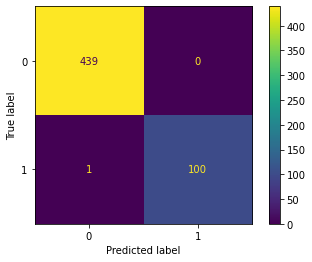

In [74]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=y_test_TNF, y_pred=y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [75]:
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from IPython import display

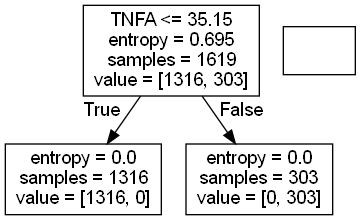

In [76]:
dot_data = export_graphviz(clf_TNF,feature_names=['TNFA'])
graph = graph_from_dot_data(dot_data)
graph.write_png('./images/decision_tree_TNF.png')
display.Image("./images/decision_tree_TNF.png", width="700")

In [77]:
from sklearn.ensemble import RandomForestClassifier
model_TNF = RandomForestClassifier(n_estimators=100, criterion='gini')
model_TNF.fit(X_train_TNF, y_train_TNF)
y_pred = model_TNF.predict(X_test_TNF)

In [78]:
from sklearn.metrics import accuracy_score
print('Exactitud - Accuracy: %.3f' % accuracy_score(y_true=y_test_TNF, y_pred=y_pred))

Exactitud - Accuracy: 0.998


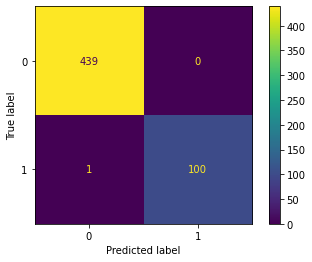

In [79]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model_TNF, X_test_TNF, y_test_TNF)

<a id="11"></a>
### Red Neuronal TNF-$\alpha$
[back to top](#0)

In [80]:
from IPython.display import HTML
from tabulate import tabulate

In [81]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
df_TNF[['TNFA']] = sc.fit_transform(df_TNF[['TNFA']])
df_TNF.head()

,subject_accession,gender,study_time_collected,name,TNFA,flag
0,SUB210882,Female,0.63,Original Cohort,-0.21,0
1,SUB211535,Male,0.83,Original Cohort,-0.21,0
2,SUB212435,Female,3.58,Original Cohort,-0.21,0
3,SUB211932,Female,0.83,Original Cohort,-0.21,0
4,SUB211500,Male,1.45,Original Cohort,-0.21,0


In [82]:
X_TNF = df_TNF[['TNFA']].values
y_TNF = df_TNF['flag'].values

In [83]:
from sklearn.model_selection import train_test_split
X_train_TNF, X_test_TNF, y_train_TNF, y_test_TNF =train_test_split(X_TNF, y_TNF, test_size=0.3, random_state=123, stratify=y_TNF)

## Importación de la clase del perceptrón multicapa
from sklearn.neural_network import MLPClassifier

## Inicialización y creación del objeto clasificador
best_score = 0
mejor_neuronas= 0
neuronas = []
score_train = []
score_test = []
columnas = ['nº neuronas', 'train score', 'test score']
for i in range(4,100):
    mlp = MLPClassifier(hidden_layer_sizes=(i, i-3), max_iter=3000,activation = 'relu',solver='sgd',random_state=1, learning_rate='adaptive',learning_rate_init=0.015)
    mlp.fit(X_train_TNF, y_train_TNF)
    score_train.append(mlp.score(X_train_TNF, y_train_TNF))
    score_test.append(mlp.score(X_test_TNF, y_test_TNF))
    neuronas.append(i)
    if mlp.score(X_test_TNF, y_test_TNF) > best_score:
        best_score = mlp.score(X_test_TNF, y_test_TNF)
        mejor_neuronas = i
df = pd.DataFrame(list(zip(neuronas, score_train, score_test)),
               columns = columnas)
df = df.set_index(columnas[0])
print (tabulate(df,headers=columnas, tablefmt='psql'))
HTML("<b>El mejor score en el test se consigue con {} neuronas, con una exactitud del {:.3f}</b>".format(mejor_neuronas,best_score))

In [84]:
capasOcultas=[4]
print(capasOcultas)
nn_TNFA = NeuralNetwork(eta=0.025, epocas=9000, hiddenLayers=capasOcultas, minibatch_size=100, shuffle=False, seed=1)
nn_TNFA.fit(X_train_TNF, y_train_TNF)

[4]
Epoca =====> 1 Coste ====> 2.4515293539992102
Epoca =====> 1001 Coste ====> 0.032439652500454406
Epoca =====> 2001 Coste ====> 0.02075039977214657
Epoca =====> 3001 Coste ====> 0.0161418988721159
Epoca =====> 4001 Coste ====> 0.01354772058332506
Epoca =====> 5001 Coste ====> 0.011832366835375072
Epoca =====> 6001 Coste ====> 0.010589580711957527
Epoca =====> 7001 Coste ====> 0.00963473353076525
Epoca =====> 8001 Coste ====> 0.008870492817334636
Epoca =====> 9000 Coste ====> 0.00824065306893202


In [85]:
y_pred_train= nn_TNFA.predict(X_train_TNF)

In [86]:
from sklearn.metrics import accuracy_score
print('Exactitud - Accuracy: %.4f' % float(100.0*accuracy_score(y_true=y_train_TNF, y_pred=y_pred_train)))

Exactitud - Accuracy: 100.0000


In [87]:
from sklearn.metrics import confusion_matrix
cm_train = confusion_matrix(y_train_TNF, y_pred_train)
cm_train

array([[1228,    0],
       [   0,  283]], dtype=int64)

In [88]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_train_TNF, y_pred=y_pred_train, target_names=['Normal', 'Alterado']))

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      1228
    Alterado       1.00      1.00      1.00       283

    accuracy                           1.00      1511
   macro avg       1.00      1.00      1.00      1511
weighted avg       1.00      1.00      1.00      1511



In [89]:
y_pred_train= nn_TNFA.predict(X_test_TNF)

In [90]:
from sklearn.metrics import accuracy_score
print('Exactitud - Accuracy: %.4f' % float(100.0*accuracy_score(y_true=y_test_TNF, y_pred=y_pred_train)))

Exactitud - Accuracy: 99.8457


In [91]:
from sklearn.metrics import confusion_matrix
cm_train = confusion_matrix(y_test_TNF, y_pred_train)
cm_train

array([[527,   0],
       [  1, 120]], dtype=int64)

In [92]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_test_TNF, y_pred=y_pred_train, target_names=['Normal', 'Alterado']))

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       527
    Alterado       1.00      0.99      1.00       121

    accuracy                           1.00       648
   macro avg       1.00      1.00      1.00       648
weighted avg       1.00      1.00      1.00       648



<a id="6"></a>
## Clasificación IL-1$\beta$
[back to top](#0)

In [93]:
df_IL1B = df_1[['subject_accession','gender','study_time_collected','name','IL1B']]
df_IL1B['flag'] = np.where(df_IL1B['IL1B'] >= 0.5, 1, 0)
df_IL1B

,subject_accession,gender,study_time_collected,name,IL1B,flag
0,SUB210882,Female,0.63,Original Cohort,2.80,1
1,SUB211535,Male,0.83,Original Cohort,1.20,1
2,SUB212435,Female,3.58,Original Cohort,0.20,0
3,SUB211932,Female,0.83,Original Cohort,0.10,0
4,SUB211500,Male,1.45,Original Cohort,0.10,0
...,...,...,...,...,...,...
2334,SUB212739,Male,0.00,Original Cohort,0.40,0
2335,SUB210920,Female,3.04,Original Cohort,0.30,0
2337,SUB211023,Female,0.24,Original Cohort,4.30,1
2338,SUB212480,Male,1.05,Original Cohort,0.60,1


In [94]:
X_IL1B = df_IL1B[['IL1B']].values
y_IL1B = df_IL1B['flag'].values

In [95]:
from sklearn.model_selection import train_test_split
X_train_IL1B, X_test_IL1B, y_train_IL1B, y_test_IL1B =train_test_split(X_IL1B, y_IL1B, test_size=0.25, random_state=123, stratify=y_IL1B)

In [96]:
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train_IL1B, X_test_IL1B, y_train_IL1B, y_test_IL1B)
print(models)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 19.33it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
AdaBoostClassifier                 1.00               1.00     1.00      1.00   
KNeighborsClassifier               1.00               1.00     1.00      1.00   
XGBClassifier                      1.00               1.00     1.00      1.00   
SGDClassifier                      1.00               1.00     1.00      1.00   
RandomForestClassifier             1.00               1.00     1.00      1.00   
Perceptron                         1.00               1.00     1.00      1.00   
PassiveAggressiveClassifier        1.00               1.00     1.00      1.00   
NuSVC                              1.00               1.00     1.00      1.00   
BaggingClassifier                  1.00               1.00     1.00      1.00   
LGBMClassifier                     1.00               1.00     1.00      1.00   
DecisionTreeClassifier      

In [97]:
clf_IL1B = DecisionTreeClassifier(criterion="entropy",random_state=0)
clf_IL1B.fit(X_train_IL1B, y_train_IL1B)
y_pred = clf_IL1B.predict(X_test_IL1B)
print('Exactitud - Accuracy: %.3f' % accuracy_score(y_true=y_test_IL1B, y_pred=y_pred))

Exactitud - Accuracy: 1.000


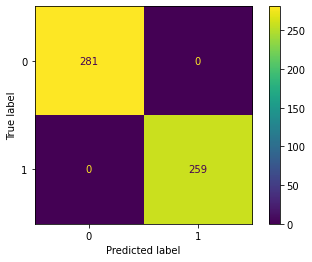

In [98]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=y_test_IL1B, y_pred=y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [99]:
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from IPython import display

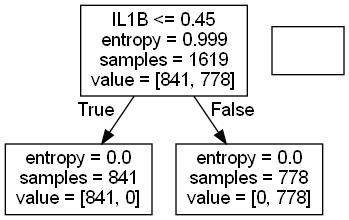

In [100]:
dot_data = export_graphviz(clf_IL1B,feature_names=['IL1B'])
graph = graph_from_dot_data(dot_data)
graph.write_png('./images/decision_tree_IL1B.png')
display.Image("./images/decision_tree_IL1B.png", width="700")

In [101]:
from sklearn.ensemble import RandomForestClassifier
model_TNF = RandomForestClassifier(n_estimators=100, criterion='gini')
model_TNF.fit(X_train_IL1B, y_train_IL1B)
y_pred = model_TNF.predict(X_test_IL1B)

In [102]:
from sklearn.metrics import accuracy_score
print('Exactitud - Accuracy: %.3f' % accuracy_score(y_true=y_test_IL1B, y_pred=y_pred))

Exactitud - Accuracy: 1.000


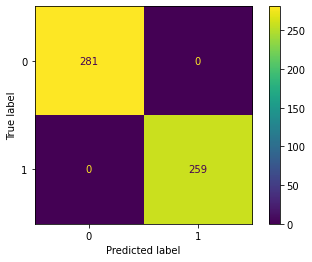

In [103]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model_TNF, X_test_IL1B, y_test_IL1B)

<a id="12"></a>
### Red Neuronal Clasificación IL-1$\beta$
[back to top](#0)

In [104]:
from IPython.display import HTML
from tabulate import tabulate

In [105]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
df_IL1B[['IL1B']] = sc.fit_transform(df_IL1B[['IL1B']])
df_IL1B.head()

,subject_accession,gender,study_time_collected,name,IL1B,flag
0,SUB210882,Female,0.63,Original Cohort,0.18,1
1,SUB211535,Male,0.83,Original Cohort,0.00,1
2,SUB212435,Female,3.58,Original Cohort,-0.11,0
3,SUB211932,Female,0.83,Original Cohort,-0.12,0
4,SUB211500,Male,1.45,Original Cohort,-0.12,0


In [106]:
X_IL1B = df_IL1B[['IL1B']].values
y_IL1B = df_IL1B['flag'].values

In [107]:
X_train_IL1B, X_test_IL1B, y_train_IL1B, y_test_IL1B =train_test_split(X_IL1B, y_IL1B, test_size=0.3, random_state=123, stratify=y_IL1B)

## Importación de la clase del perceptrón multicapa
from sklearn.neural_network import MLPClassifier

## Inicialización y creación del objeto clasificador
best_score = 0
mejor_neuronas= 0
neuronas = []
score_train = []
score_test = []
columnas = ['nº neuronas', 'train score', 'test score']
for i in range(4,100):
    mlp = MLPClassifier(hidden_layer_sizes=(i, i-3), max_iter=3000,activation = 'relu',solver='sgd',random_state=1, learning_rate='adaptive',learning_rate_init=0.015)
    mlp.fit(X_train_IL1B, y_train_IL1B)
    score_train.append(mlp.score(X_train_IL1B, y_train_IL1B))
    score_test.append(mlp.score(X_test_IL1B, y_test_IL1B))
    neuronas.append(i)
    if mlp.score(X_test_IL1B, y_test_IL1B) > best_score:
        best_score = mlp.score(X_test_IL1B, y_test_IL1B)
        mejor_neuronas = i
df = pd.DataFrame(list(zip(neuronas, score_train, score_test)),
               columns = columnas)
df = df.set_index(columnas[0])
print (tabulate(df,headers=columnas, tablefmt='psql'))
HTML("<b>El mejor score en el test se consigue con {} neuronas, con una exactitud del {:.3f}</b>".format(mejor_neuronas,best_score))

In [108]:
capasOcultas=[6]
print(capasOcultas)
nn_IL1B = NeuralNetwork(eta=0.025, epocas=4000, hiddenLayers=capasOcultas, minibatch_size=100, shuffle=False, seed=1)
nn_IL1B.fit(X_train_IL1B, y_train_IL1B)

[6]
Epoca =====> 1 Coste ====> 3.7627774609143967
Epoca =====> 1001 Coste ====> 0.07958612263232354
Epoca =====> 2001 Coste ====> 0.021999915717956165
Epoca =====> 3001 Coste ====> 0.01134740868790991
Epoca =====> 4000 Coste ====> 0.007304751104364993


In [109]:
y_pred_train= nn_IL1B.predict(X_train_IL1B)

In [110]:
from sklearn.metrics import accuracy_score
print('Exactitud - Accuracy: %.4f' % float(100.0*accuracy_score(y_true=y_train_IL1B, y_pred=y_pred_train)))

Exactitud - Accuracy: 100.0000


In [111]:
from sklearn.metrics import confusion_matrix
cm_train = confusion_matrix(y_train_IL1B, y_pred_train)
cm_train

array([[785,   0],
       [  0, 726]], dtype=int64)

In [112]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_train_IL1B, y_pred=y_pred_train, target_names=['Normal', 'Alterado']))

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       785
    Alterado       1.00      1.00      1.00       726

    accuracy                           1.00      1511
   macro avg       1.00      1.00      1.00      1511
weighted avg       1.00      1.00      1.00      1511



In [113]:
y_pred_train= nn_IL1B.predict(X_test_IL1B)

In [114]:
from sklearn.metrics import accuracy_score
print('Exactitud - Accuracy: %.4f' % float(100.0*accuracy_score(y_true=y_test_IL1B, y_pred=y_pred_train)))

Exactitud - Accuracy: 100.0000


In [115]:
from sklearn.metrics import confusion_matrix
cm_train = confusion_matrix(y_test_IL1B, y_pred_train)
cm_train

array([[337,   0],
       [  0, 311]], dtype=int64)

In [116]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_test_IL1B, y_pred=y_pred_train, target_names=['Normal', 'Alterado']))

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       337
    Alterado       1.00      1.00      1.00       311

    accuracy                           1.00       648
   macro avg       1.00      1.00      1.00       648
weighted avg       1.00      1.00      1.00       648



<a id="13"></a>
## PRUEBAS ENTRENAMIENTO
[back to top](#0)

In [117]:
import numpy as np

# Valores mínimos para cada columna
min_val1 = 70
min_val2 = 50
min_val3 = 35
min_val4 = 0.5

# Generar 10 valores aleatorios con decimales para cada columna
factor = 100 # Escala los valores para que estén entre 0 y 100
IL6 = factor * np.random.rand(100) 
IL8 = factor * np.random.rand(100) 
TNFA = factor * np.random.rand(100) 
IL1B = 2 * np.random.rand(100) 

# Crear un array de NumPy con los valores generados
data = np.array([IL6, IL8, TNFA, IL1B]).T

In [118]:
import pandas as pd
df = pd.DataFrame(data, columns=['IL6', 'IL8', 'TNFA', 'IL1B'])
df

,IL6,IL8,TNFA,IL1B
0,94.24,67.03,80.38,0.65
1,47.35,41.21,34.10,0.51
2,22.69,45.85,37.38,1.83
3,11.61,78.29,52.07,1.68
4,50.68,33.71,68.22,1.16
...,...,...,...,...
95,95.92,76.85,70.64,0.41
96,73.55,76.03,93.56,1.99
97,96.07,14.37,55.87,1.66
98,47.23,13.29,5.39,1.79


In [119]:
def predict_flags(data, models):
    # Creamos una copia del conjunto de datos original
    result = data.copy()
    # Iteramos sobre cada columna en el conjunto de datos
    for col in data.columns:
        # Obtenemos el modelo correspondiente para esa columna
        model = models[col]
        
        # Realizamos la predicción y la guardamos en una nueva columna "flag"
        result[f"{col}_flag"] = model.predict(result[[col]])

    # Devolvemos la nueva tabla de datos con las columnas "flag" agregadas
    return result

In [120]:
resultados = predict_flags(df, {
    "IL6": clf_IL6,
    "IL8": clf_IL8,
    "TNFA": clf_TNF,
    "IL1B": clf_IL1B
})
resultados

,IL6,IL8,TNFA,IL1B,IL6_flag,IL8_flag,TNFA_flag,IL1B_flag
0,94.24,67.03,80.38,0.65,1,1,1,1
1,47.35,41.21,34.10,0.51,0,0,0,1
2,22.69,45.85,37.38,1.83,0,0,1,1
3,11.61,78.29,52.07,1.68,0,1,1,1
4,50.68,33.71,68.22,1.16,0,0,1,1
...,...,...,...,...,...,...,...,...
95,95.92,76.85,70.64,0.41,1,1,1,0
96,73.55,76.03,93.56,1.99,1,1,1,1
97,96.07,14.37,55.87,1.66,1,0,1,1
98,47.23,13.29,5.39,1.79,0,0,0,1


In [121]:
from tabulate import tabulate

total_valores = resultados["IL6"].count()
tabla = []
for col in resultados.columns:
    if "flag" in col:
        num_ones = resultados[col].value_counts()[1]
        num_zero = total_valores - num_ones
        col_name = col.replace("_flag","")
        tabla.append([col_name, num_ones, num_zero])
print(tabulate(tabla, headers=["Columna", "Valores alterados", "Valores normales"]))

Columna      Valores alterados    Valores normales
---------  -------------------  ------------------
IL6                         31                  69
IL8                         38                  62
TNFA                        66                  34
IL1B                        70                  30


In [122]:
# Contar número de filas con 1s en cada columna
counts = []
for col in resultados.columns:
    if "flag" in col:    
        count = sum(resultados[col] == 1)
        counts.append(count)

# Contar número de filas con 1s en todas las columnas hasta que el número de columnas con 1s sea 0
results = []
for i in range(5):
    count = sum((resultados == 1).sum(axis=1) == i)
    results.append([i, count])

# Imprimir resultados
print("\nNúmero de filas con valores alterados en n columnas:\n")
print(tabulate(results, headers=["Citoquinas alteradas", "Frecuencia"]))


Número de filas con valores alterados en n columnas:

  Citoquinas alteradas    Frecuencia
----------------------  ------------
                     0             1
                     1            26
                     2            44
                     3            25
                     4             4


<a id="7"></a>
## Lab-Test
[back to top](#0)

In [123]:
import mysql.connector

# Conexión a la base de datos
cnx = mysql.connector.connect(user='root', password='Supersayan0,07',
                              host='localhost', database='sdy1662')

# Consulta SQL para obtener la tabla
query = "SELECT * FROM lab_test_filtr"

# Lectura de la tabla en un DataFrame de Pandas
df2 = pd.read_sql(query, cnx)

# Cierre de la conexión
cnx.close()
df_2 = df2[df2['study_time_collected'] != 999]
df_2

,subject_accession,biosample_accession,Age,gender,study_time_collected,name,CRP,D_DIMER,FERRETIN,FIBRINOGEN,...,LYMPHOCYTE_NO,LYMPHOCYTE_PERCENT,MEAN_PLATELET_VOLUME,MONOCYTE_NO,MONOCYTE_PERCENT,NEUTROPHIL_NO,NEUTROPHIL_PERCENT,PLATELET,RBC_COUNT,WBC_COUNT
0,SUB210704,BS1052752,67.00,Female,0.00,Original Cohort,6.76,1.14,9.56,9.32,...,0.80,9.00,9.90,0.40,4.70,7.30,90.00,286.00,3.65,8.50
1,SUB210705,BS1052806,37.00,Female,0.00,Original Cohort,7.48,-1.09,9.79,9.38,...,2.00,21.90,7.10,0.50,5.00,6.60,71.70,290.00,4.94,9.10
2,SUB210706,BS1053391,65.00,Male,0.00,Original Cohort,8.55,1.94,11.89,10.12,...,1.20,6.60,9.90,0.50,3.60,16.80,91.50,283.00,4.80,18.40
3,SUB210707,BS1053393,68.00,Female,0.00,Original Cohort,7.02,-1.47,11.27,NaN,...,0.30,11.00,8.20,0.10,3.20,2.90,90.40,123.00,4.25,3.30
4,SUB210708,BS1053395,66.00,Male,0.00,Original Cohort,6.28,-0.92,11.24,NaN,...,0.60,10.00,8.90,0.40,7.10,5.20,82.70,128.00,5.03,6.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2335,SUB213039,BS1058195,85.00,Male,0.00,Validation Cohort,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2336,SUB213040,BS1058200,59.00,Male,0.00,Validation Cohort,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2337,SUB213041,BS1058207,68.00,Male,0.00,Validation Cohort,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2338,SUB213042,BS1058209,57.00,Male,0.00,Validation Cohort,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
df_2.describe()

,Age,study_time_collected,CRP,D_DIMER,FERRETIN,FIBRINOGEN,IL6,Albumin,ALT,ANION_GAP,...,LYMPHOCYTE_NO,LYMPHOCYTE_PERCENT,MEAN_PLATELET_VOLUME,MONOCYTE_NO,MONOCYTE_PERCENT,NEUTROPHIL_NO,NEUTROPHIL_PERCENT,PLATELET,RBC_COUNT,WBC_COUNT
count,2340.00,2340.00,1811.00,1642.00,1808.00,1092.00,126.00,1818.00,1793.00,1871.00,...,1009.00,1159.00,1196.00,1009.00,1159.00,1161.00,1159.00,1187.00,1197.00,1195.00
mean,60.17,2.80,5.80,0.79,9.13,8.98,6.62,3.17,5.05,10.23,...,1.04,14.37,8.80,0.52,6.94,7.37,77.60,257.28,4.22,9.11
std,18.84,11.60,2.34,1.55,2.14,0.60,1.85,0.73,1.34,4.08,...,0.83,10.99,1.22,0.32,4.15,5.28,13.90,124.94,0.79,5.95
min,0.00,0.00,-2.32,-1.89,2.32,4.58,2.35,1.10,2.32,-7.00,...,0.10,0.00,5.70,0.00,0.00,0.00,0.00,4.00,1.00,0.10
25%,51.00,0.00,4.69,-0.42,7.73,8.61,5.47,2.70,4.17,7.70,...,0.60,7.30,7.90,0.30,4.05,4.10,72.00,174.00,3.75,5.60
50%,63.00,0.00,6.53,0.71,9.27,9.07,6.73,3.10,4.86,10.00,...,0.90,11.60,8.70,0.50,6.40,6.10,81.00,237.00,4.28,7.70
75%,73.00,0.54,7.52,1.71,10.64,9.41,7.72,3.70,5.78,12.45,...,1.20,18.60,9.50,0.70,9.10,9.20,87.10,313.00,4.74,11.05
max,89.00,185.10,9.81,7.23,15.03,10.30,11.59,5.70,12.48,36.55,...,10.10,89.70,15.90,3.20,44.00,49.16,97.20,1131.00,6.95,71.50


In [125]:
df_2.describe(include='object')

,subject_accession,biosample_accession,gender,name
count,2340,2340,2340,2340
unique,2340,2340,3,2
top,SUB210704,BS1052752,Male,Original Cohort
freq,1,1,1342,1484


In [126]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2340 entries, 0 to 2339
Data columns (total 62 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   subject_accession        2340 non-null   object 
 1   biosample_accession      2340 non-null   object 
 2   Age                      2340 non-null   float64
 3   gender                   2340 non-null   object 
 4   study_time_collected     2340 non-null   float64
 5   name                     2340 non-null   object 
 6   CRP                      1811 non-null   float64
 7   D_DIMER                  1642 non-null   float64
 8   FERRETIN                 1808 non-null   float64
 9   FIBRINOGEN               1092 non-null   float64
 10  IL6                      126 non-null    float64
 11  Albumin                  1818 non-null   float64
 12  ALT                      1793 non-null   float64
 13  ANION_GAP                1871 non-null   float64
 14  APTT                    

In [127]:
# Conexión a la base de datos
cnx = mysql.connector.connect(user='root', password='Supersayan0,07',
                              host='localhost', database='sdy1662')

# Consulta SQL para obtener la tabla
query = "SELECT * FROM covid_wbc"

# Lectura de la tabla en un DataFrame de Pandas
df5 = pd.read_sql(query, cnx)

# Cierre de la conexión
cnx.close()

df5 = df5.replace(['NA'], np.nan, regex=True)
df5

,subject_accession,gender,Age,name,SARS_CoV_2_PCR,BASOPHIL_NO,BASOPHIL_PERCENT,EOSINOPHIL_NO,EOSINOPHIL_PERCENT,LYMPHOCYTE_NO,LYMPHOCYTE_PERCENT,MEAN_PLATELET_VOLUME,MONOCYTE_NO,MONOCYTE_PERCENT,NEUTROPHIL_NO,NEUTROPHIL_PERCENT,PLATELET,RBC_COUNT,WBC_COUNT
0,SUB211119,Male,53.00,Original Cohort,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SUB211118,Male,29.00,Original Cohort,DETECTED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SUB211117,Male,41.00,Original Cohort,DETECTED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SUB211116,Male,65.00,Original Cohort,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SUB212874,Male,60.00,Original Cohort,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2335,SUB212996,Male,13.00,Validation Cohort,NOT-DETECTED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2336,SUB212197,Male,83.00,Validation Cohort,DETECTED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2337,SUB212196,Male,23.00,Validation Cohort,NOT-DETECTED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2338,SUB212995,Male,36.00,Validation Cohort,NOT-DETECTED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subject_accession     2340 non-null   object 
 1   gender                2340 non-null   object 
 2   Age                   2340 non-null   float64
 3   name                  2340 non-null   object 
 4   SARS_CoV_2_PCR        2158 non-null   object 
 5   BASOPHIL_NO           1009 non-null   float64
 6   BASOPHIL_PERCENT      1159 non-null   float64
 7   EOSINOPHIL_NO         1009 non-null   float64
 8   EOSINOPHIL_PERCENT    1159 non-null   float64
 9   LYMPHOCYTE_NO         1009 non-null   float64
 10  LYMPHOCYTE_PERCENT    1159 non-null   float64
 11  MEAN_PLATELET_VOLUME  1196 non-null   float64
 12  MONOCYTE_NO           1009 non-null   float64
 13  MONOCYTE_PERCENT      1159 non-null   float64
 14  NEUTROPHIL_NO         1161 non-null   float64
 15  NEUTROPHIL_PERCENT   

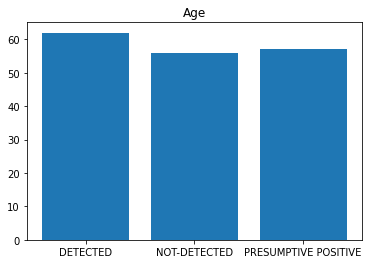

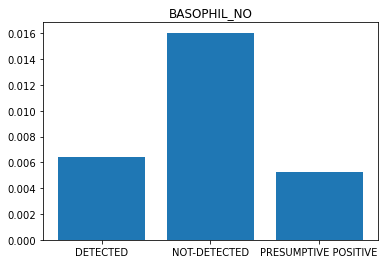

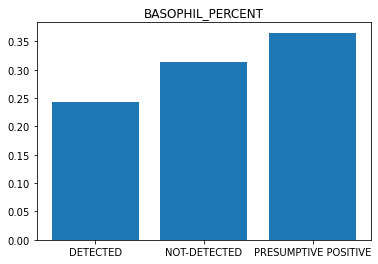

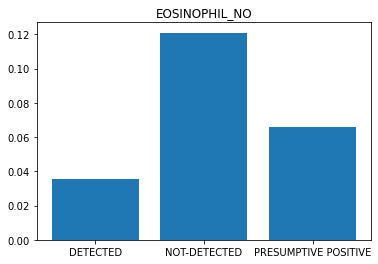

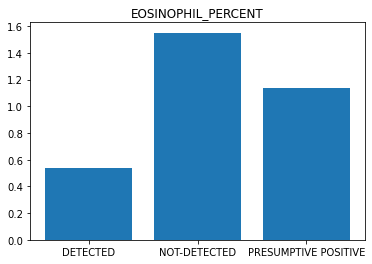

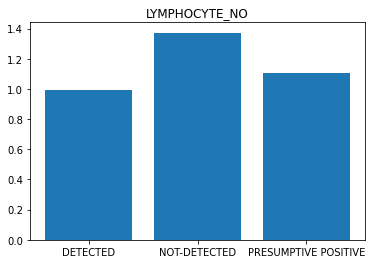

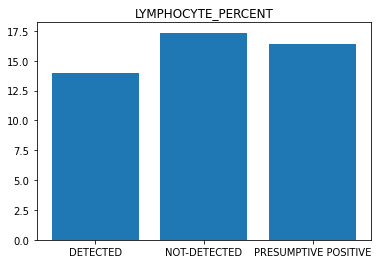

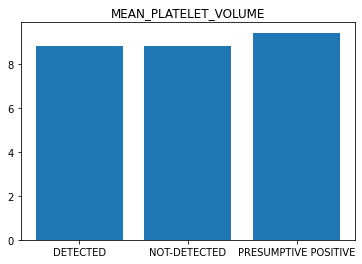

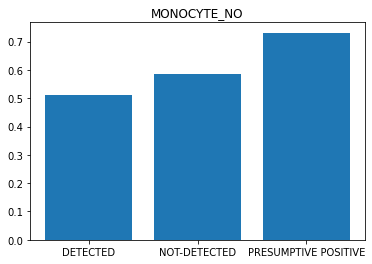

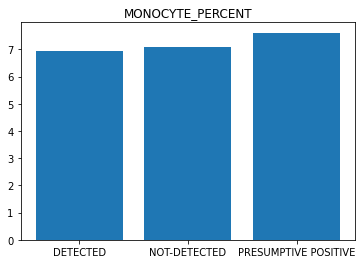

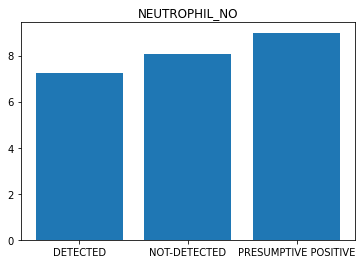

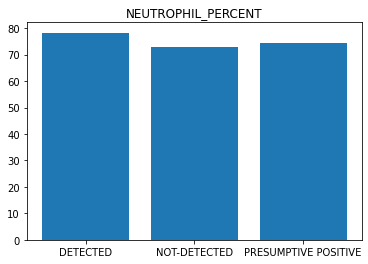

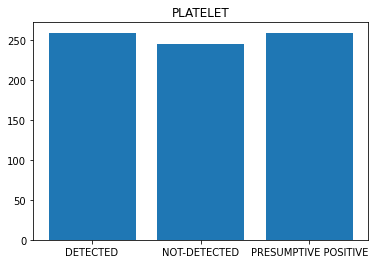

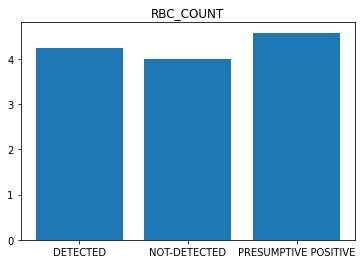

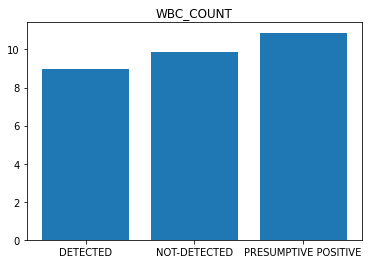

In [129]:
df5_1 = df5.groupby('SARS_CoV_2_PCR').mean()

for col in df5_1.columns:
    plt.bar(df5_1.index, df5_1[col])
    plt.title(col)
    plt.show()

<a id="8"></a>
## Comorbilidades
[back to top](#0)

In [130]:
import mysql.connector

# Conexión a la base de datos
cnx = mysql.connector.connect(user='root', password='Supersayan0,07',
                              host='localhost', database='sdy1662')

# Consulta SQL para obtener la tabla
query = "SELECT * FROM comorbilidades"

# Lectura de la tabla en un DataFrame de Pandas
df3 = pd.read_sql(query, cnx)

# Cierre de la conexión
cnx.close()
df3 = df3.replace(['Not Available', 'NOT AVAILABLE','Not available','NA','Not Specified'], np.nan, regex=True)
df3 = df3.drop('DECEASED_Question', axis = 1)
df3 = df3.drop('Acute_Respiratory_Distress_Syndrome', axis = 1)
df3 = df3.drop('SEVERITY', axis = 1)

In [131]:
df3

,subject_accession,gender,Age,SMOKING_STATUS,DIABETES,ARDS,CANCER_FLAG,BMI,TEMP_MAX,HEART_RATE_MAX,...,SLEEP_APNEA,ATRIAL_FIBRILLATION,CORONARY_ARTERY_DISEASE,CHRONIC_VIRAL_HEPATITIS,ALCOHOLIC_NONALCOHOLIC_LIVER_DISEASE,ACUTE_KIDNEY_INJURY,ACUTE_VENOUS_THROMBOEMBOLISM,CEREBRAL_INFARCTION,INTRACEREBRAL_HEMORRHAGE,SARS_CoV_2_PCR
0,SUB210704,Female,67.00,NON-SMOKER,1,1,0,23.19,37.39,133.00,...,None,None,None,None,None,None,None,None,None,DETECTED
1,SUB210705,Female,37.00,NON-SMOKER,0,0,1,39.94,37.83,97.00,...,None,None,None,None,None,None,None,None,None,DETECTED
2,SUB210706,Male,65.00,NON-SMOKER,0,1,0,22.96,39.06,116.00,...,None,None,None,None,None,None,None,None,None,DETECTED
3,SUB210707,Female,68.00,NON-SMOKER,0,0,1,29.45,37.44,98.00,...,None,None,None,None,None,None,None,None,None,DETECTED
4,SUB210708,Male,66.00,SMOKER,0,0,0,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,DETECTED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2335,SUB213039,Male,85.00,None,None,None,None,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
2336,SUB213040,Male,59.00,None,None,None,None,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
2337,SUB213041,Male,68.00,None,None,None,None,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
2338,SUB213042,Male,57.00,None,None,None,None,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None


In [132]:
df3.groupby(['gender']).count()['subject_accession']

gender
Female     990
Male      1342
Name: subject_accession, dtype: int64

In [133]:
#qué columnas tienen los datos
df3.columns

Index(['subject_accession', 'gender', 'Age', 'SMOKING_STATUS', 'DIABETES',
       'ARDS', 'CANCER_FLAG', 'BMI', 'TEMP_MAX', 'HEART_RATE_MAX',
       'RESP_RATE_MAX', 'SYSTOL_BP_MAX', 'DIASTOL_BP_MAX', 'O2SAT_MIN',
       'DECEASED', 'DISEASE_SEVERITY', 'SEVERITY_NUMERIC', 'MAX_SEVERITY',
       'SOFA_SCORE', 'MAX_SOFA_SCORE', 'BLOOD_TYPE', 'Chronic_Kidney_Disease',
       'Admission_to_Hospital', 'ASTHMA', 'Congestive_Heart_Failure',
       'Chronic_Obstructive_Pulmonary_Disease', 'SLEEP_APNEA',
       'ATRIAL_FIBRILLATION', 'CORONARY_ARTERY_DISEASE',
       'CHRONIC_VIRAL_HEPATITIS', 'ALCOHOLIC_NONALCOHOLIC_LIVER_DISEASE',
       'ACUTE_KIDNEY_INJURY', 'ACUTE_VENOUS_THROMBOEMBOLISM',
       'CEREBRAL_INFARCTION', 'INTRACEREBRAL_HEMORRHAGE', 'SARS_CoV_2_PCR'],
      dtype='object')

In [134]:
#qué tamaño tienen los datos
df3.shape

(2340, 36)

In [135]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 36 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   subject_accession                      2340 non-null   object 
 1   gender                                 2332 non-null   object 
 2   Age                                    2340 non-null   float64
 3   SMOKING_STATUS                         1707 non-null   object 
 4   DIABETES                               2174 non-null   object 
 5   ARDS                                   2173 non-null   object 
 6   CANCER_FLAG                            2172 non-null   object 
 7   BMI                                    1987 non-null   float64
 8   TEMP_MAX                               1831 non-null   float64
 9   HEART_RATE_MAX                         1838 non-null   float64
 10  RESP_RATE_MAX                          1838 non-null   float64
 11  SYST

In [136]:
#cómo se distribuyen las variables numéricas
df3.describe()

,Age,BMI,TEMP_MAX,HEART_RATE_MAX,RESP_RATE_MAX,SYSTOL_BP_MAX,DIASTOL_BP_MAX,O2SAT_MIN
count,2340.00,1987.00,1831.00,1838.00,1838.00,1825.00,1825.00,1165.00
mean,60.17,28.53,37.68,104.89,26.44,144.17,81.88,91.47
std,18.84,7.62,1.28,22.70,10.72,24.71,14.25,6.60
min,0.00,10.82,3.39,46.00,16.00,80.00,48.00,22.00
25%,51.00,23.59,37.00,89.12,20.00,128.00,73.00,90.00
50%,63.00,27.37,37.50,101.00,22.00,140.00,81.00,93.00
75%,73.00,32.28,38.33,118.00,30.00,158.00,89.50,95.00
max,89.00,75.04,46.22,211.00,181.00,285.00,200.00,100.00


In [137]:
df3.describe(include='object')

,subject_accession,gender,SMOKING_STATUS,DIABETES,ARDS,CANCER_FLAG,DECEASED,DISEASE_SEVERITY,SEVERITY_NUMERIC,MAX_SEVERITY,...,SLEEP_APNEA,ATRIAL_FIBRILLATION,CORONARY_ARTERY_DISEASE,CHRONIC_VIRAL_HEPATITIS,ALCOHOLIC_NONALCOHOLIC_LIVER_DISEASE,ACUTE_KIDNEY_INJURY,ACUTE_VENOUS_THROMBOEMBOLISM,CEREBRAL_INFARCTION,INTRACEREBRAL_HEMORRHAGE,SARS_CoV_2_PCR
count,2340,2332,1707,2174,2173,2172,2051,1775,1747,1842,...,739,739,680,680,680,680,680,680,680,2158
unique,2340,2,3,2,2,2,2,3,3,3,...,2,2,2,2,2,2,2,2,2,3
top,SUB210704,Male,NON-SMOKER,0,0,0,0,Moderate COVID-19,1,1,...,0,0,0,0,0,0,0,0,0,DETECTED
freq,1,1342,1019,1682,1945,1874,1700,1115,1115,989,...,716,658,580,664,650,628,667,673,677,1451


In [138]:
from tabulate import tabulate

for col in df3.columns:
    if df3[col].dtype == 'object'and col != 'subject_accession' and col != 'CANCER_DIAGNOSIS_DESCRIPTION':
        group = df3.groupby([col])['subject_accession'].count().reset_index()
        print(tabulate(group, headers=[col, 'count'], tablefmt='psql'))

+----+----------+---------+
|    | gender   |   count |
|----+----------+---------|
|  0 | Female   |     990 |
|  1 | Male     |    1342 |
+----+----------+---------+
+----+------------------+---------+
|    | SMOKING_STATUS   |   count |
|----+------------------+---------|
|  0 | NON-SMOKER       |    1019 |
|  1 | QUIT             |     529 |
|  2 | SMOKER           |     159 |
+----+------------------+---------+
+----+------------+---------+
|    |   DIABETES |   count |
|----+------------+---------|
|  0 |          0 |    1682 |
|  1 |          1 |     492 |
+----+------------+---------+
+----+--------+---------+
|    |   ARDS |   count |
|----+--------+---------|
|  0 |      0 |    1945 |
|  1 |      1 |     228 |
+----+--------+---------+
+----+---------------+---------+
|    |   CANCER_FLAG |   count |
|----+---------------+---------|
|  0 |             0 |    1874 |
|  1 |             1 |     298 |
+----+---------------+---------+
+----+------------+---------+
|    |   DECEASE

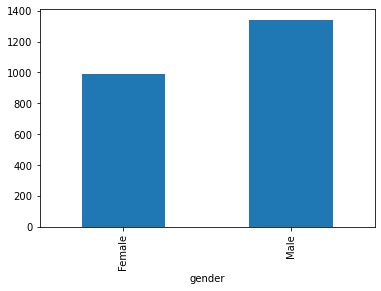

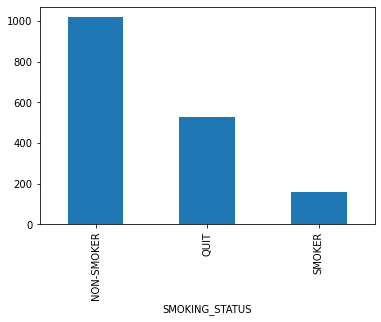

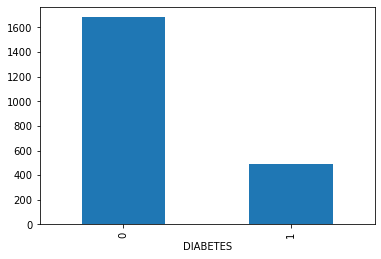

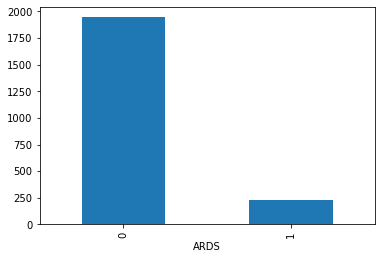

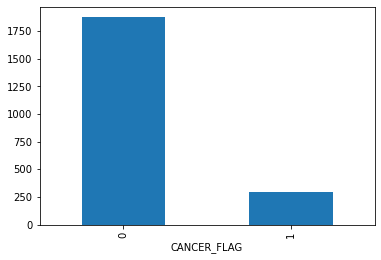

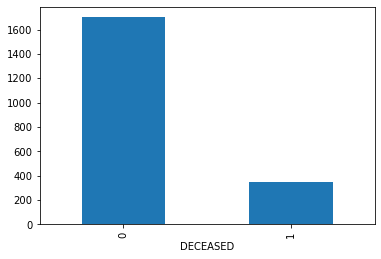

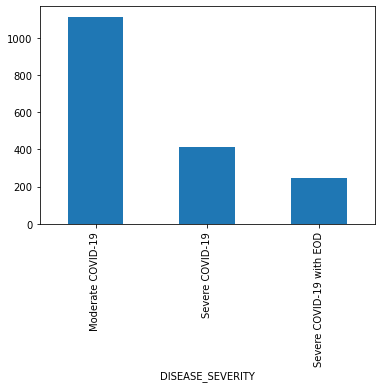

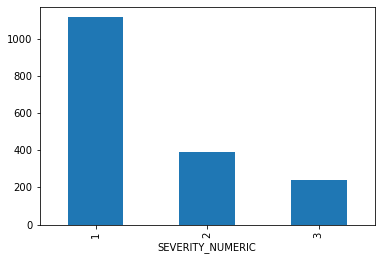

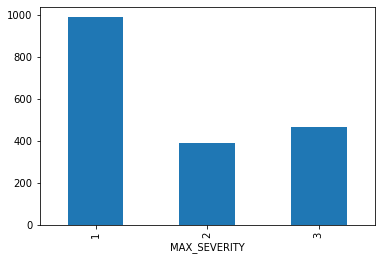

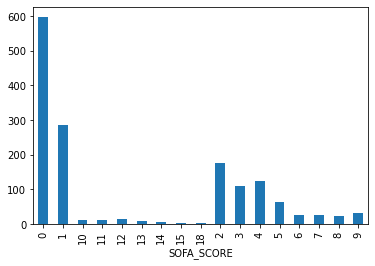

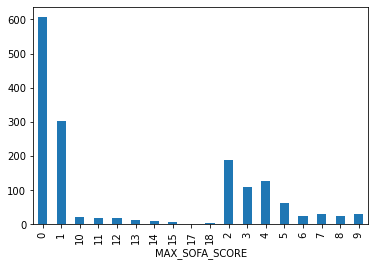

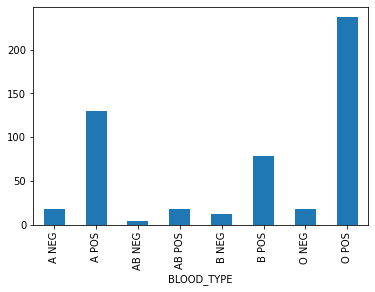

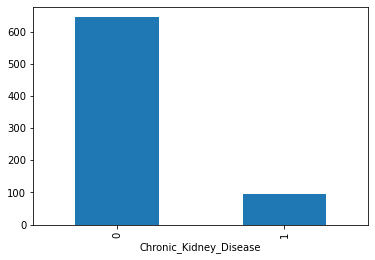

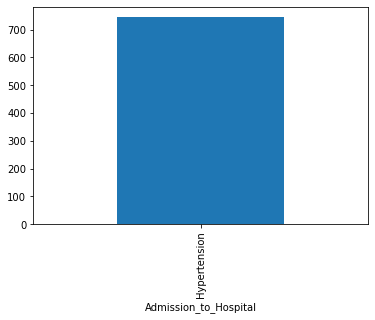

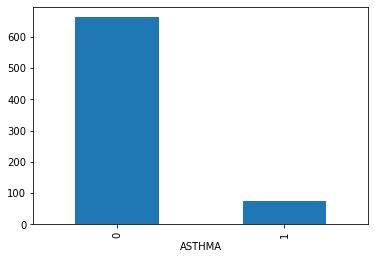

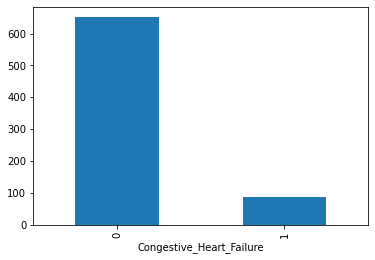

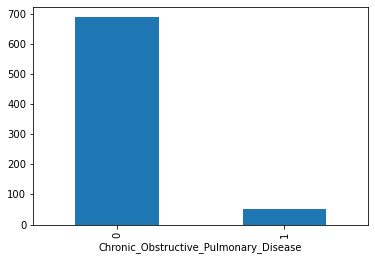

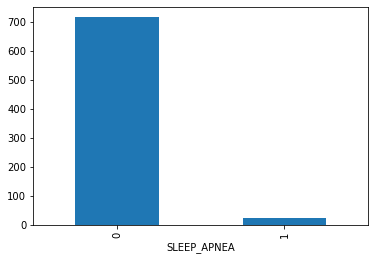

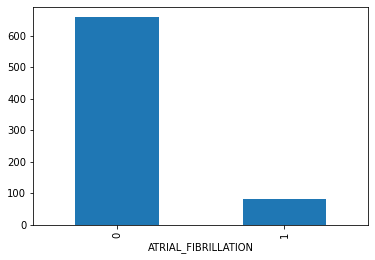

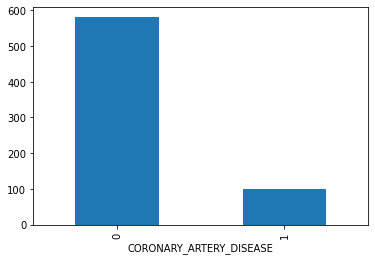

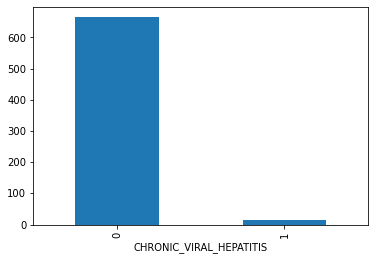

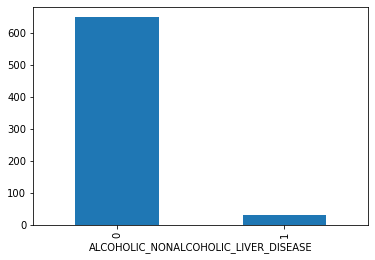

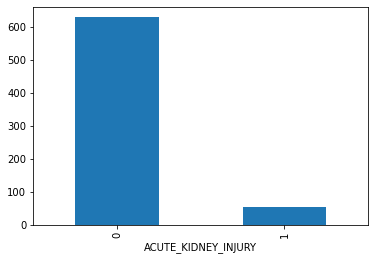

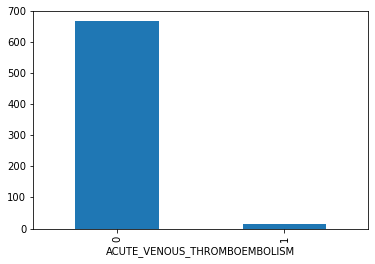

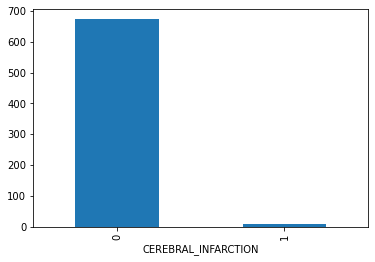

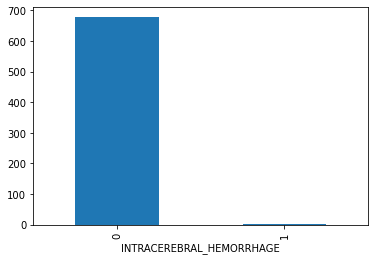

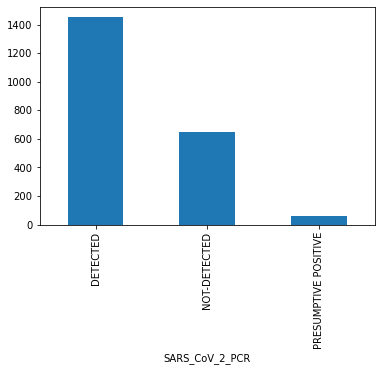

In [139]:
for col in df3.columns:
    if df3[col].dtype == 'object'and col != 'subject_accession' and col != 'CANCER_DIAGNOSIS_DESCRIPTION':
        grouped_name = df3.groupby([col])['subject_accession'].count()
        grouped_name.plot.bar()
        plt.show()

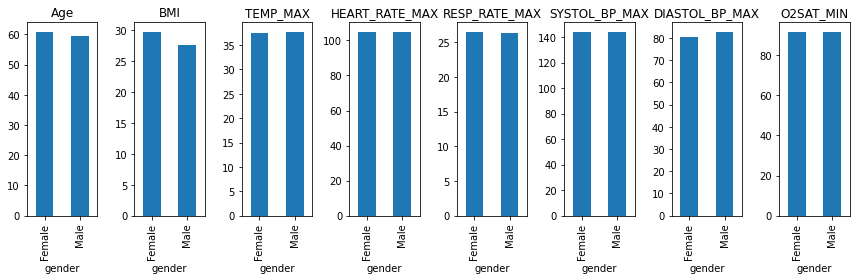

In [140]:
df3_1 = df3.groupby('gender').mean()

# Crear una figura con cuatro gráficos
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(12, 4))

# Generar los gráficos de barras para cada columna

for i, columna in enumerate(df3_1.select_dtypes(include=['float64'])):
    df3_1[columna].plot(kind='bar', ax=axes[i])
    axes[i].set_title(columna)

# Ajustar el espaciado entre los gráficos y mostrar la figura
fig.tight_layout()
plt.show()

### RELACIÓN ENTRE DETECTED Y NON-DETECTED CON LA SEVERIDAD Y LOS FALLECIMIENTOS

In [141]:
# Dividimos la tabla en dos nuevas tablas
df_detected = df3.loc[(df3['SARS_CoV_2_PCR'] == 'DETECTED') | (df3['SARS_CoV_2_PCR'] == 'PRESUMPTIVE POSITIVE')].reset_index(drop=True)
df_not_detected = df3.loc[df3['SARS_CoV_2_PCR'] == 'NOT-DETECTED'].reset_index(drop=True)

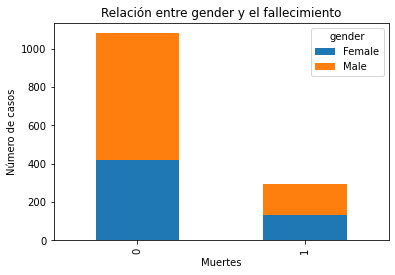

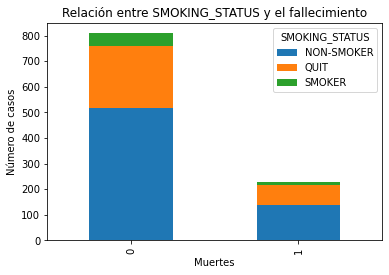

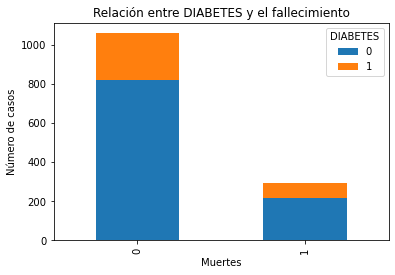

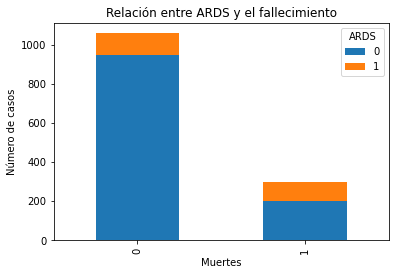

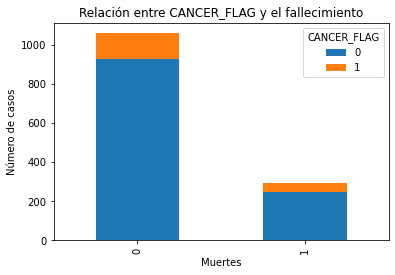

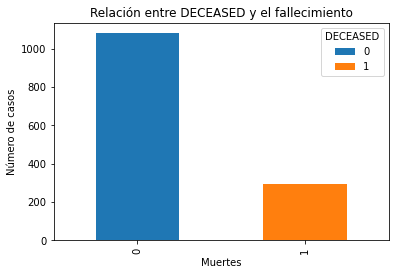

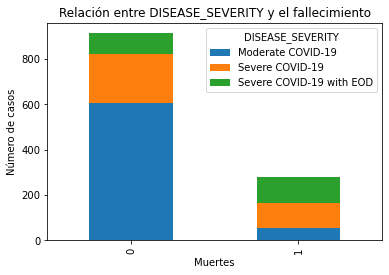

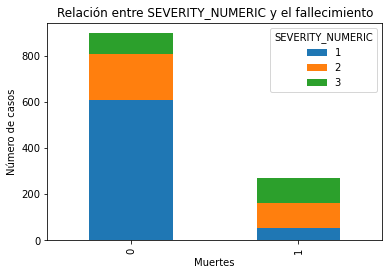

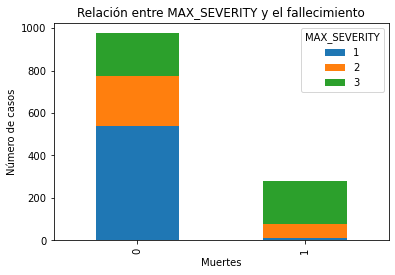

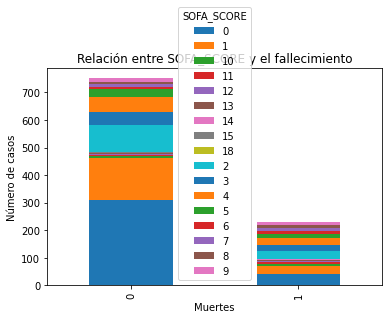

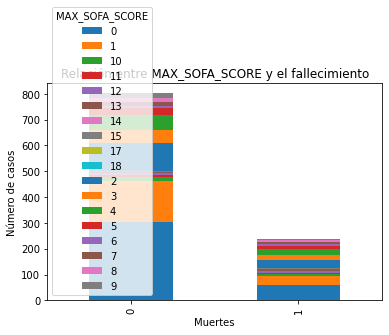

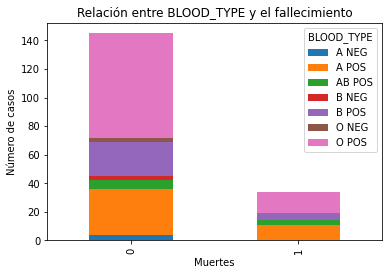

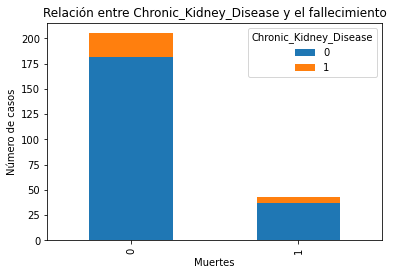

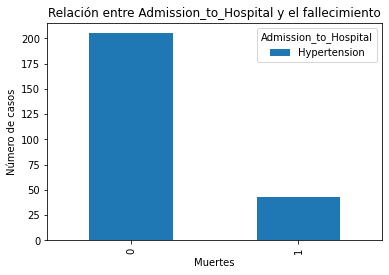

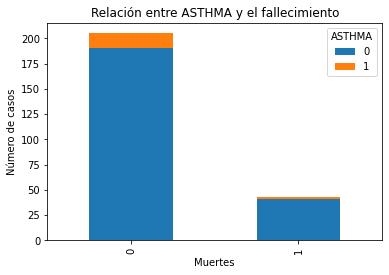

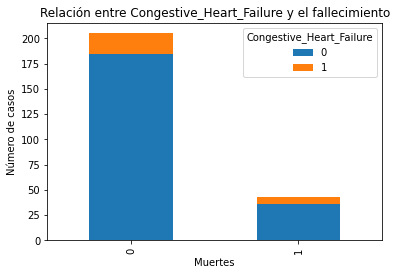

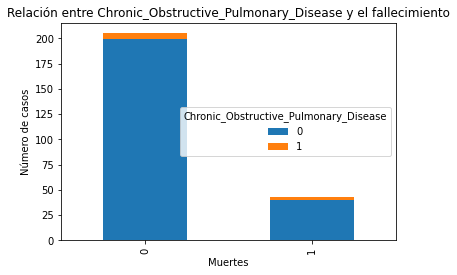

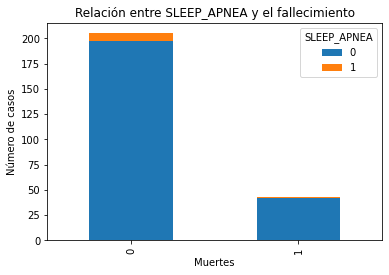

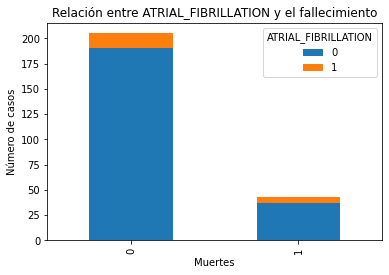

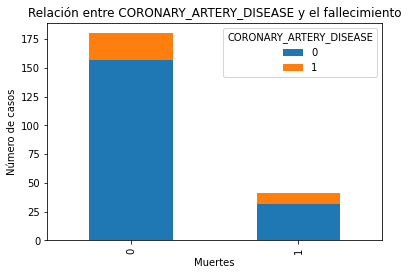

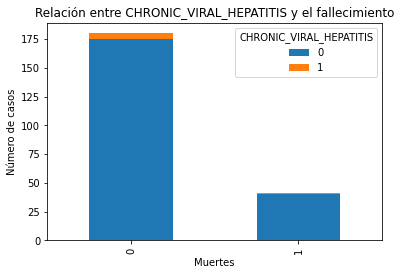

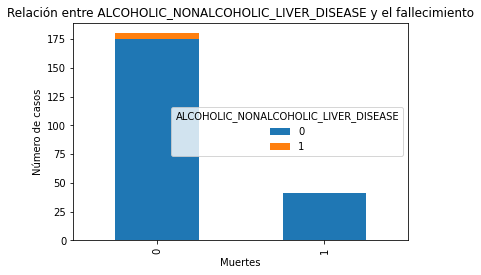

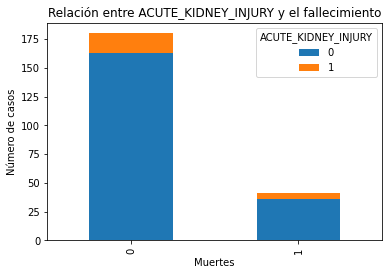

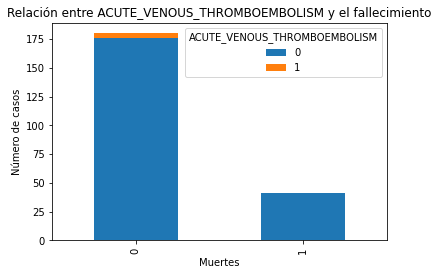

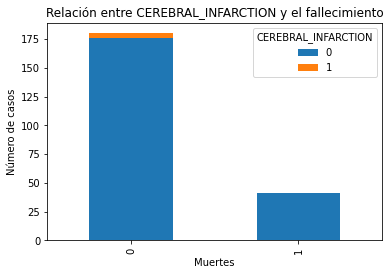

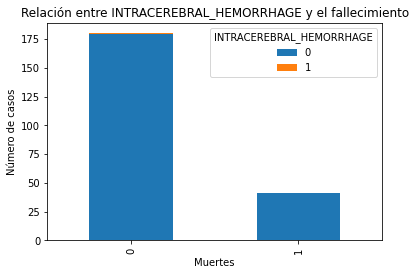

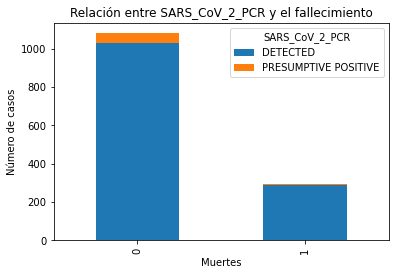

In [142]:
for col in df_detected.columns:
    if df_detected[col].dtype == 'object'and col != 'subject_accession' and col != 'CANCER_DIAGNOSIS_DESCRIPTION':
        # Crear una tabla de contingencia para contar el número de casos en cada categoría
        tabla_contingencia = pd.crosstab(index=df_detected['DECEASED'], columns=df_detected[col])

        # Graficar tabla de contingencia como gráfico de barras apiladas
        tabla_contingencia.plot(kind='bar', stacked=True)

        # Añadir etiquetas y título
        plt.xlabel('Muertes')
        plt.ylabel('Número de casos')
        plt.title(f'Relación entre {col} y el fallecimiento')

        # Mostrar gráfico
        plt.show()

In [143]:
for col in df_detected.columns:
    if df3[col].dtype == 'object'and col != 'subject_accession' and col != 'CANCER_DIAGNOSIS_DESCRIPTION':
        # Crear una tabla de contingencia para contar el número de casos en cada categoría
        tabla_contingencia = pd.crosstab(index=df_detected['DECEASED'], columns=df_detected[col])
        print(tabla_contingencia)

gender    Female  Male
DECEASED              
0            421   659
1            130   166
SMOKING_STATUS  NON-SMOKER  QUIT  SMOKER
DECEASED                                
0                      517   241      51
1                      138    77      14
DIABETES    0    1
DECEASED          
0         818  241
1         219   77
ARDS        0    1
DECEASED          
0         945  113
1         202   94
CANCER_FLAG    0    1
DECEASED             
0            929  130
1            249   47
DECEASED     0    1
DECEASED           
0         1080    0
1            0  296
DISEASE_SEVERITY  Moderate COVID-19  Severe COVID-19  Severe COVID-19 with EOD
DECEASED                                                                      
0                               608              213                        92
1                                53              112                       115
SEVERITY_NUMERIC    1    2    3
DECEASED                       
0                 608  200   88
1           

In [144]:
id = df_detected.loc[(df_detected['DECEASED'] == '1') & (df_detected['CANCER_FLAG'] == '1'), 'subject_accession']

In [145]:
id

3       SUB210707
12      SUB210717
75      SUB210850
100     SUB210879
113     SUB210894
123     SUB210905
138     SUB210923
200     SUB211006
268     SUB211086
328     SUB211313
383     SUB211376
398     SUB211393
400     SUB211395
434     SUB211436
529     SUB211544
554     SUB211572
563     SUB211583
608     SUB211637
616     SUB211647
634     SUB211667
642     SUB211675
661     SUB211698
695     SUB211738
722     SUB211767
730     SUB211778
739     SUB211788
748     SUB211804
774     SUB211837
903     SUB212386
905     SUB212388
1042    SUB212619
1055    SUB212634
1073    SUB212653
1129    SUB212716
1134    SUB212721
1148    SUB212737
1167    SUB212762
1168    SUB212763
1204    SUB212815
1260    SUB210732
1273    SUB210776
1287    SUB211172
1302    SUB211211
1309    SUB211225
1349    SUB212054
1483    SUB212961
1496    SUB213011
Name: subject_accession, dtype: object

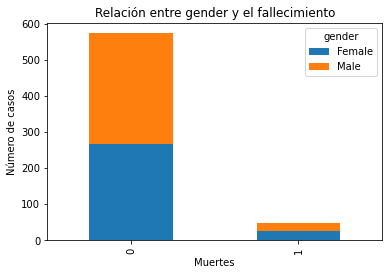

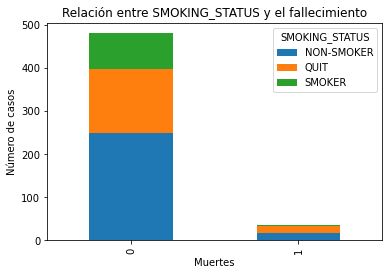

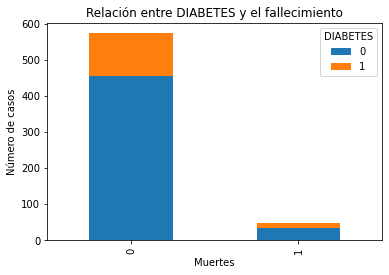

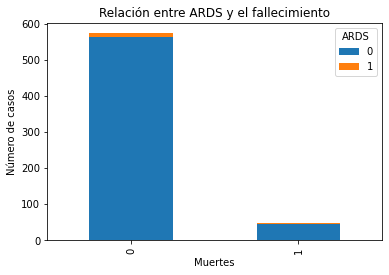

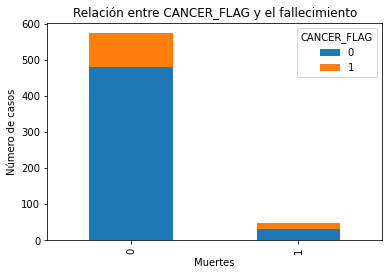

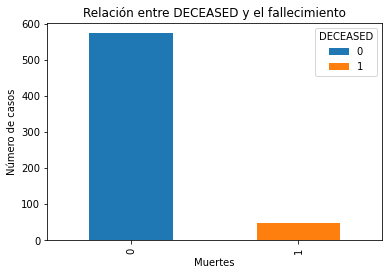

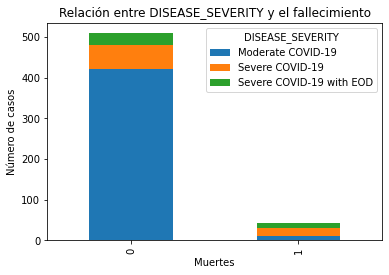

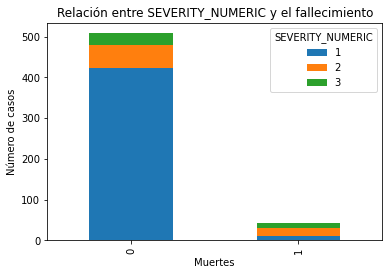

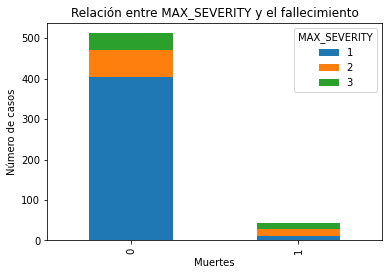

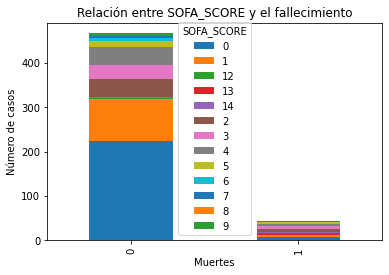

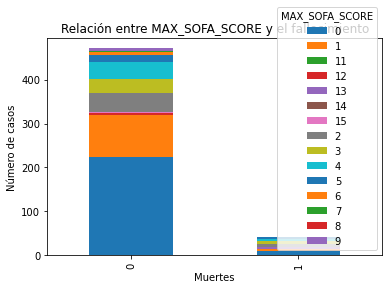

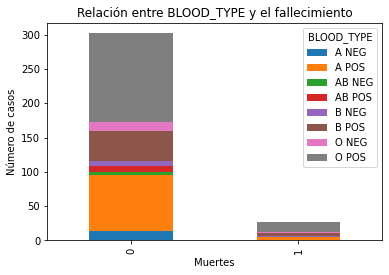

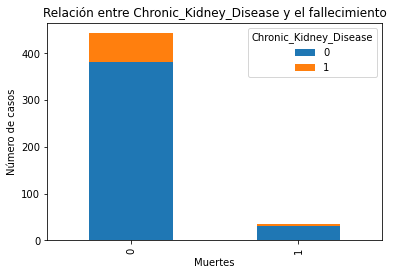

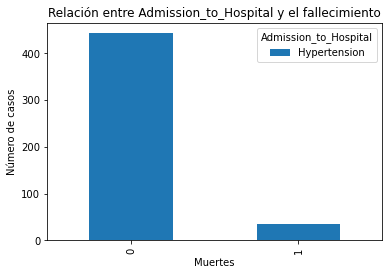

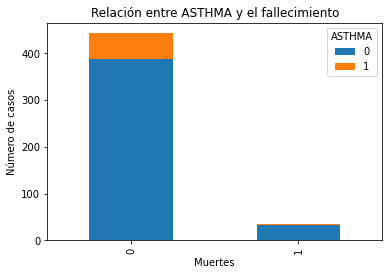

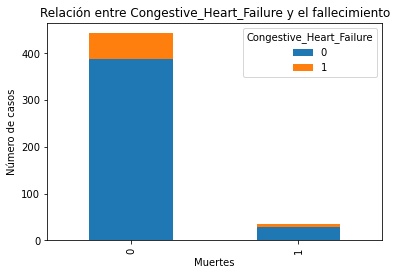

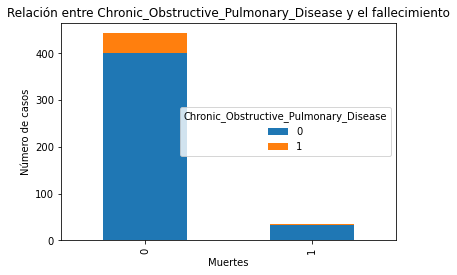

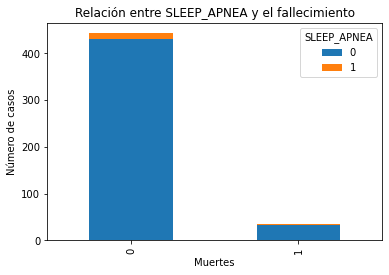

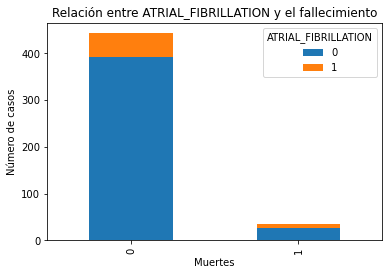

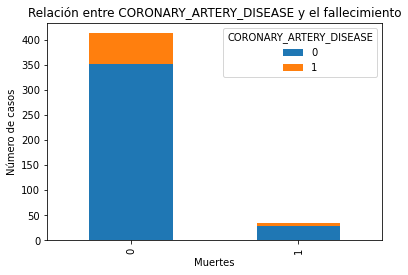

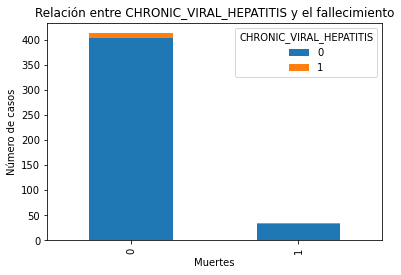

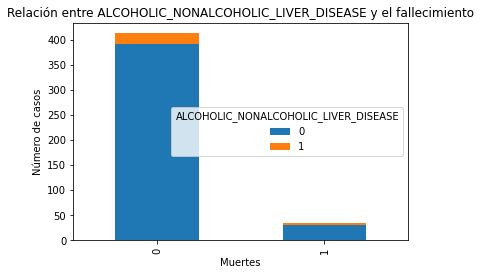

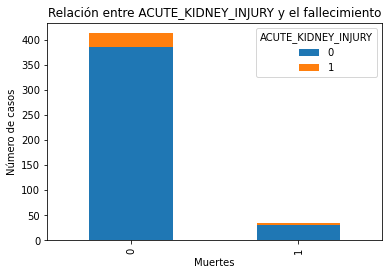

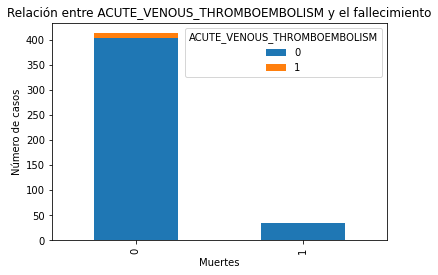

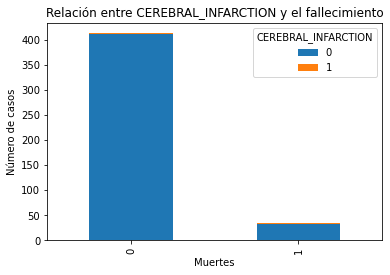

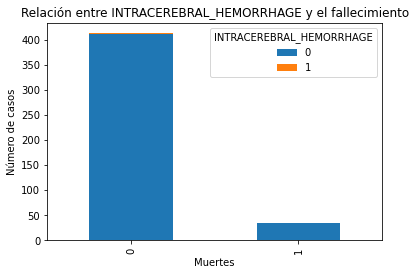

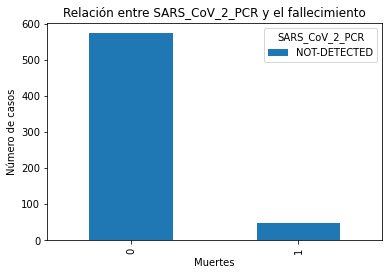

In [146]:
for col in df_not_detected.columns:
    if df_not_detected[col].dtype == 'object'and col != 'subject_accession' and col != 'CANCER_DIAGNOSIS_DESCRIPTION':
        # Crear una tabla de contingencia para contar el número de casos en cada categoría
        tabla_contingencia = pd.crosstab(index=df_not_detected['DECEASED'], columns=df_not_detected[col])

        # Graficar tabla de contingencia como gráfico de barras apiladas
        tabla_contingencia.plot(kind='bar', stacked=True)

        # Añadir etiquetas y título
        plt.xlabel('Muertes')
        plt.ylabel('Número de casos')
        plt.title(f'Relación entre {col} y el fallecimiento')

        # Mostrar gráfico
        plt.show()

In [147]:
for col in df_not_detected.columns:
    if df_not_detected[col].dtype == 'object'and col != 'subject_accession' and col != 'CANCER_DIAGNOSIS_DESCRIPTION':
        # Crear una tabla de contingencia para contar el número de casos en cada categoría
        tabla_contingencia = pd.crosstab(index=df_not_detected['DECEASED'], columns=df_not_detected[col])
        print(tabla_contingencia)

gender    Female  Male
DECEASED              
0            267   306
1             25    22
SMOKING_STATUS  NON-SMOKER  QUIT  SMOKER
DECEASED                                
0                      250   149      82
1                       18    15       2
DIABETES    0    1
DECEASED          
0         456  117
1          35   12
ARDS        0   1
DECEASED         
0         563  10
1          45   2
CANCER_FLAG    0   1
DECEASED            
0            481  92
1             32  15
DECEASED    0   1
DECEASED         
0         573   0
1           0  47
DISEASE_SEVERITY  Moderate COVID-19  Severe COVID-19  Severe COVID-19 with EOD
DECEASED                                                                      
0                               422               59                        28
1                                12               19                        12
SEVERITY_NUMERIC    1   2   3
DECEASED                     
0                 422  58  28
1                  12  18  12
MAX_

In [148]:
id_2 = df_not_detected.loc[(df_not_detected['DECEASED'] == '1') & (df_not_detected['CANCER_FLAG'] == '1'), 'subject_accession']

<a id="14"></a>
## Relaciones citoquinas alteradas-severidad
[back to top](#0)

In [149]:
import mysql.connector

# Conexión a la base de datos
cnx = mysql.connector.connect(user='root', password='Supersayan0,07',
                              host='localhost', database='sdy1662')

# Consulta SQL para obtener la tabla
query = "SELECT * FROM Final"

# Lectura de la tabla en un DataFrame de Pandas
data = pd.read_sql(query, cnx)

# Cierre de la conexión
cnx.close()
data = data.replace(['Not Available', 'NOT AVAILABLE','Not available','NA','Not Specified'], np.nan, regex=True)
data = data[data['study_time_collected'] != 999]
data = data.drop('DECEASED_Question', axis = 1)
data

,subject_accession,gender,Age,study_time_collected,name,IL6,IL8,TNFA,IL1B,DECEASED,DISEASE_SEVERITY,SEVERITY,SEVERITY_NUMERIC,MAX_SEVERITY,SARS_CoV_2_PCR
0,SUB210704,Female,67.00,0.88,Original Cohort,118.00,40.70,18.10,0.60,0,Severe COVID-19 with EOD,Severe COVID-19 with EOD,3,3,DETECTED
1,SUB210705,Female,37.00,1.19,Original Cohort,70.80,29.30,19.20,0.40,0,Severe COVID-19,Severe COVID-19,2,2,DETECTED
2,SUB210706,Male,65.00,3.19,Original Cohort,10663.00,997.00,83.10,4.40,1,Severe COVID-19,Severe COVID-19,NaN,3,DETECTED
3,SUB210707,Female,68.00,0.73,Original Cohort,119.00,90.80,15.60,0.40,1,Moderate COVID-19,Moderate COVID-19,1,3,DETECTED
4,SUB210708,Male,66.00,0.97,Original Cohort,109.00,21.60,19.50,0.40,0,Moderate COVID-19,Moderate COVID-19,1,1,DETECTED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2335,SUB212793,Male,85.00,3.50,Original Cohort,327.00,37.10,37.20,0.30,1,Severe COVID-19 with EOD,Severe COVID-19 with EOD,3,3,DETECTED
2336,SUB212802,Male,75.00,0.74,Original Cohort,70.10,54.40,35.60,0.70,0,Severe COVID-19,Severe COVID-19,2,3,DETECTED
2337,SUB212812,Male,59.00,2.19,Original Cohort,72.90,55.70,38.50,3.50,1,Moderate COVID-19,Moderate COVID-19,1,1,DETECTED
2338,SUB212843,Female,61.00,0.96,Original Cohort,154.00,38.00,32.60,0.80,0,Severe COVID-19,Severe COVID-19,2,3,DETECTED


In [150]:
data['IL6_flag'] = np.where(data['IL6'] > 70, 1, 0)
data['IL8_flag'] = np.where(data['IL8'] > 50, 1, 0)
data['TNFA_flag'] = np.where(data['TNFA'] > 35, 1, 0)
data['IL1B_flag'] = np.where(data['IL1B'] > 0.5, 1, 0)
data

,subject_accession,gender,Age,study_time_collected,name,IL6,IL8,TNFA,IL1B,DECEASED,DISEASE_SEVERITY,SEVERITY,SEVERITY_NUMERIC,MAX_SEVERITY,SARS_CoV_2_PCR,IL6_flag,IL8_flag,TNFA_flag,IL1B_flag
0,SUB210704,Female,67.00,0.88,Original Cohort,118.00,40.70,18.10,0.60,0,Severe COVID-19 with EOD,Severe COVID-19 with EOD,3,3,DETECTED,1,0,0,1
1,SUB210705,Female,37.00,1.19,Original Cohort,70.80,29.30,19.20,0.40,0,Severe COVID-19,Severe COVID-19,2,2,DETECTED,1,0,0,0
2,SUB210706,Male,65.00,3.19,Original Cohort,10663.00,997.00,83.10,4.40,1,Severe COVID-19,Severe COVID-19,NaN,3,DETECTED,1,1,1,1
3,SUB210707,Female,68.00,0.73,Original Cohort,119.00,90.80,15.60,0.40,1,Moderate COVID-19,Moderate COVID-19,1,3,DETECTED,1,1,0,0
4,SUB210708,Male,66.00,0.97,Original Cohort,109.00,21.60,19.50,0.40,0,Moderate COVID-19,Moderate COVID-19,1,1,DETECTED,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2335,SUB212793,Male,85.00,3.50,Original Cohort,327.00,37.10,37.20,0.30,1,Severe COVID-19 with EOD,Severe COVID-19 with EOD,3,3,DETECTED,1,0,1,0
2336,SUB212802,Male,75.00,0.74,Original Cohort,70.10,54.40,35.60,0.70,0,Severe COVID-19,Severe COVID-19,2,3,DETECTED,1,1,1,1
2337,SUB212812,Male,59.00,2.19,Original Cohort,72.90,55.70,38.50,3.50,1,Moderate COVID-19,Moderate COVID-19,1,1,DETECTED,1,1,1,1
2338,SUB212843,Female,61.00,0.96,Original Cohort,154.00,38.00,32.60,0.80,0,Severe COVID-19,Severe COVID-19,2,3,DETECTED,1,0,0,1


In [151]:
data.dropna(subset=['MAX_SEVERITY','SARS_CoV_2_PCR'], inplace= True )

In [152]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1813 entries, 0 to 2339
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subject_accession     1813 non-null   object 
 1   gender                1813 non-null   object 
 2   Age                   1813 non-null   float64
 3   study_time_collected  1813 non-null   float64
 4   name                  1813 non-null   object 
 5   IL6                   1813 non-null   float64
 6   IL8                   1807 non-null   float64
 7   TNFA                  1809 non-null   float64
 8   IL1B                  1807 non-null   float64
 9   DECEASED              1812 non-null   object 
 10  DISEASE_SEVERITY      1741 non-null   object 
 11  SEVERITY              1124 non-null   object 
 12  SEVERITY_NUMERIC      1718 non-null   object 
 13  MAX_SEVERITY          1813 non-null   object 
 14  SARS_CoV_2_PCR        1813 non-null   object 
 15  IL6_flag             

In [153]:
df_detected_cyt = data.loc[(data['SARS_CoV_2_PCR'] == 'DETECTED') | (data['SARS_CoV_2_PCR'] == 'PRESUMPTIVE POSITIVE')].reset_index(drop=True)
df_not_detected_cyt = data.loc[data['SARS_CoV_2_PCR'] == 'NOT-DETECTED'].reset_index(drop=True)

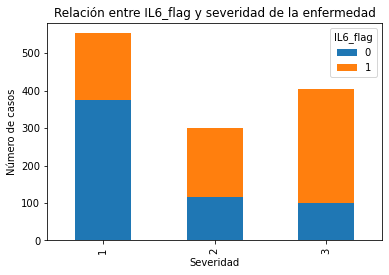

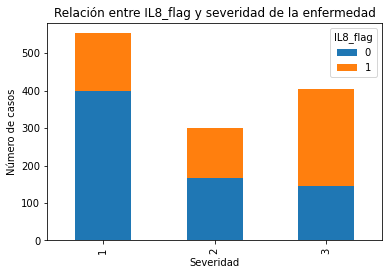

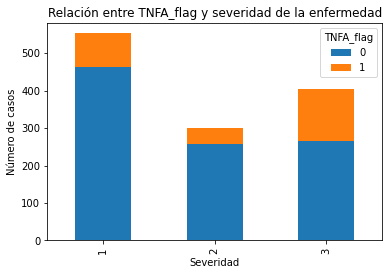

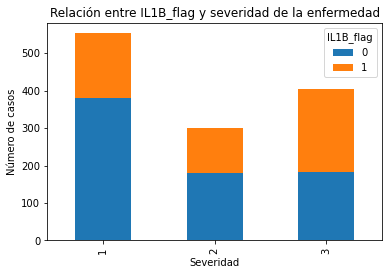

In [154]:
# Crear una lista de columnas que contienen "_flag"
flag_cols = [col for col in df_detected_cyt.columns if '_flag' in col]

# Iterar sobre cada columna y crear la tabla de contingencia y el gráfico
for col in flag_cols:
    # Crear una tabla de contingencia para contar el número de casos en cada categoría
    tabla_contingencia = pd.crosstab(index=df_detected_cyt['MAX_SEVERITY'], columns=df_detected_cyt[col])

    # Graficar tabla de contingencia como gráfico de barras apiladas
    tabla_contingencia.plot(kind='bar', stacked=True)

    # Añadir etiquetas y título
    plt.xlabel('Severidad')
    plt.ylabel('Número de casos')
    plt.title(f'Relación entre {col} y severidad de la enfermedad')

    # Mostrar gráfico
    plt.show()

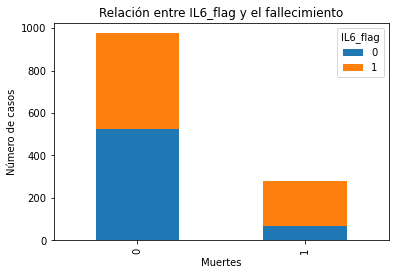

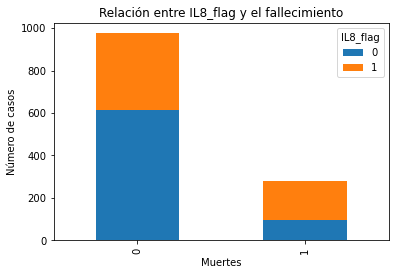

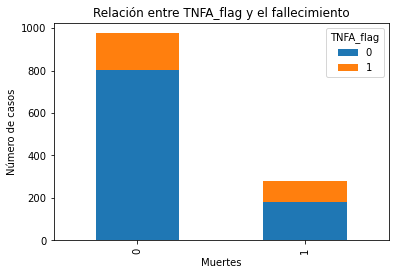

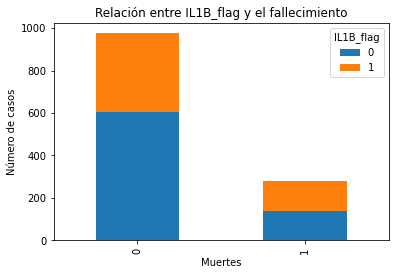

In [155]:
# Crear una lista de columnas que contienen "_flag"
flag_cols = [col for col in df_detected_cyt.columns if '_flag' in col]

# Iterar sobre cada columna y crear la tabla de contingencia y el gráfico
for col in flag_cols:
    # Crear una tabla de contingencia para contar el número de casos en cada categoría
    tabla_contingencia = pd.crosstab(index=df_detected_cyt['DECEASED'], columns=df_detected_cyt[col])

    # Graficar tabla de contingencia como gráfico de barras apiladas
    tabla_contingencia.plot(kind='bar', stacked=True)

    # Añadir etiquetas y título
    plt.xlabel('Muertes')
    plt.ylabel('Número de casos')
    plt.title(f'Relación entre {col} y el fallecimiento')

    # Mostrar gráfico
    plt.show()

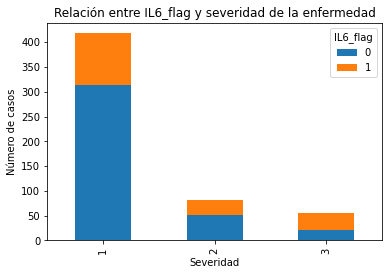

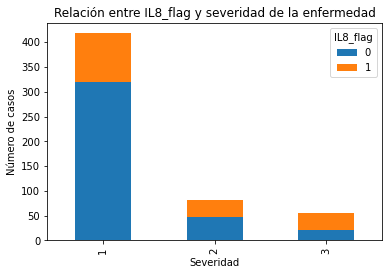

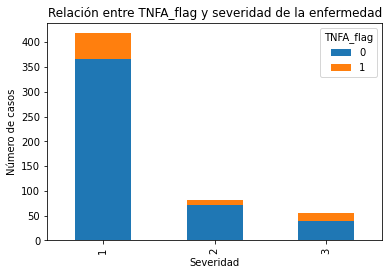

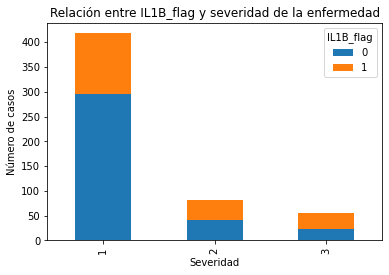

In [156]:
# Crear una lista de columnas que contienen "_flag"
flag_cols = [col for col in df_not_detected_cyt.columns if '_flag' in col]

# Iterar sobre cada columna y crear la tabla de contingencia y el gráfico
for col in flag_cols:
    # Crear una tabla de contingencia para contar el número de casos en cada categoría
    tabla_contingencia = pd.crosstab(index=df_not_detected_cyt['MAX_SEVERITY'], columns=df_not_detected_cyt[col])

    # Graficar tabla de contingencia como gráfico de barras apiladas
    tabla_contingencia.plot(kind='bar', stacked=True)

    # Añadir etiquetas y título
    plt.xlabel('Severidad')
    plt.ylabel('Número de casos')
    plt.title(f'Relación entre {col} y severidad de la enfermedad')

    # Mostrar gráfico
    plt.show()

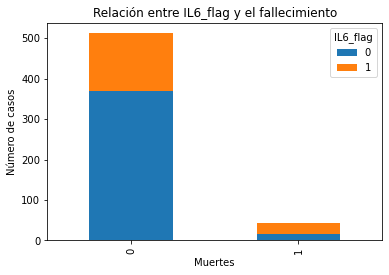

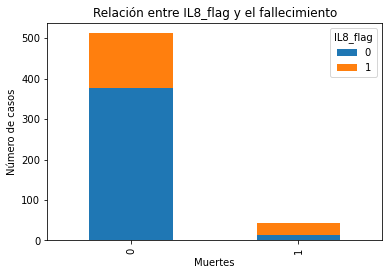

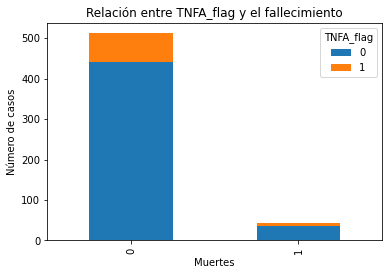

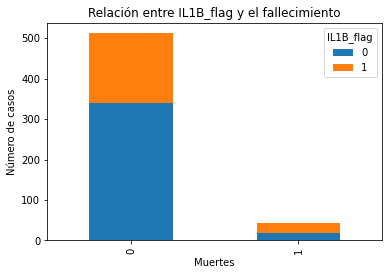

In [157]:
# Crear una lista de columnas que contienen "_flag"
flag_cols = [col for col in df_not_detected_cyt.columns if '_flag' in col]

# Iterar sobre cada columna y crear la tabla de contingencia y el gráfico
for col in flag_cols:
    # Crear una tabla de contingencia para contar el número de casos en cada categoría
    tabla_contingencia = pd.crosstab(index=df_not_detected_cyt['DECEASED'], columns=df_not_detected_cyt[col])

    # Graficar tabla de contingencia como gráfico de barras apiladas
    tabla_contingencia.plot(kind='bar', stacked=True)

    # Añadir etiquetas y título
    plt.xlabel('Muertes')
    plt.ylabel('Número de casos')
    plt.title(f'Relación entre {col} y el fallecimiento')

    # Mostrar gráfico
    plt.show()

In [158]:
cancer = data[data['subject_accession'].isin(id)]
cancer

,subject_accession,gender,Age,study_time_collected,name,IL6,IL8,TNFA,IL1B,DECEASED,DISEASE_SEVERITY,SEVERITY,SEVERITY_NUMERIC,MAX_SEVERITY,SARS_CoV_2_PCR,IL6_flag,IL8_flag,TNFA_flag,IL1B_flag
3,SUB210707,Female,68.00,0.73,Original Cohort,119.00,90.80,15.60,0.40,1,Moderate COVID-19,Moderate COVID-19,1,3,DETECTED,1,1,0,0
79,SUB210850,Female,79.00,0.81,Original Cohort,200.00,100.00,58.50,0.40,1,Moderate COVID-19,Moderate COVID-19,1,3,DETECTED,1,1,1,0
107,SUB210879,Female,61.00,1.75,Original Cohort,60.40,33.10,11.30,0.80,1,Severe COVID-19,Severe COVID-19,2,2,DETECTED,0,0,0,1
121,SUB210894,Male,88.00,5.05,Original Cohort,53.00,18.00,100.00,0.50,1,Moderate COVID-19,Moderate COVID-19,1,3,DETECTED,0,0,1,0
131,SUB210905,Female,75.00,2.19,Original Cohort,199.00,109.00,48.30,0.70,1,Severe COVID-19 with EOD,Severe COVID-19 with EOD,3,3,DETECTED,1,1,1,1
146,SUB210923,Male,63.00,115.03,Original Cohort,896.00,1249.00,44.60,0.10,1,Severe COVID-19,Severe COVID-19,2,2,DETECTED,1,1,1,0
222,SUB211006,Female,47.00,7.68,Original Cohort,541.00,39.80,21.80,0.10,1,Moderate COVID-19,Moderate COVID-19,1,3,DETECTED,1,0,0,0
297,SUB211086,Female,48.00,0.69,Original Cohort,68.30,24.80,15.20,0.40,1,Moderate COVID-19,Moderate COVID-19,1,2,DETECTED,0,0,0,0
366,SUB211313,Female,67.00,10.76,Original Cohort,99.70,104.00,23.30,2.40,1,Severe COVID-19,Severe COVID-19,2,3,DETECTED,1,1,0,1
426,SUB211376,Female,83.00,8.19,Original Cohort,50.30,180.00,18.90,0.60,1,Severe COVID-19,Severe COVID-19,2,3,DETECTED,0,1,0,1


<a id="15"></a>
## 6. PCR-COVID
[back to top](#0)

In [159]:
import mysql.connector

# Conexión a la base de datos
cnx = mysql.connector.connect(user='root', password='Supersayan0,07',
                              host='localhost', database='sdy1662')

# Consulta SQL para obtener la tabla
query = "SELECT * FROM PCR_COVID"

# Lectura de la tabla en un DataFrame de Pandas
df4 = pd.read_sql(query, cnx)

# Cierre de la conexión
cnx.close()

df4 = df4.replace(['NA'], np.nan, regex=True)
df4

,subject_accession,Age,gender,name,study_time_collected,SARS_CoV_2_PCR
0,SUB211119,53.00,Male,Original Cohort,0.00,NaN
1,SUB211118,29.00,Male,Original Cohort,0.00,DETECTED
2,SUB211117,41.00,Male,Original Cohort,0.00,DETECTED
3,SUB211116,65.00,Male,Original Cohort,0.00,NaN
4,SUB212874,60.00,Male,Original Cohort,0.00,NaN
...,...,...,...,...,...,...
2601,SUB212995,36.00,Male,Validation Cohort,0.35,NOT-DETECTED
2602,SUB211214,69.00,Male,Validation Cohort,6.00,DETECTED
2603,SUB211214,69.00,Male,Validation Cohort,1.58,DETECTED
2604,SUB211214,69.00,Male,Validation Cohort,0.58,DETECTED


In [160]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2606 entries, 0 to 2605
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subject_accession     2606 non-null   object 
 1   Age                   2606 non-null   float64
 2   gender                2606 non-null   object 
 3   name                  2606 non-null   object 
 4   study_time_collected  2606 non-null   float64
 5   SARS_CoV_2_PCR        2363 non-null   object 
dtypes: float64(2), object(4)
memory usage: 122.3+ KB


In [161]:
df4.dropna(subset=['SARS_CoV_2_PCR'], inplace= True )

In [162]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2363 entries, 1 to 2605
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subject_accession     2363 non-null   object 
 1   Age                   2363 non-null   float64
 2   gender                2363 non-null   object 
 3   name                  2363 non-null   object 
 4   study_time_collected  2363 non-null   float64
 5   SARS_CoV_2_PCR        2363 non-null   object 
dtypes: float64(2), object(4)
memory usage: 129.2+ KB


In [163]:
group = df4.groupby(['SARS_CoV_2_PCR'])['subject_accession'].count().reset_index()
print(tabulate(group, headers=['SARS_CoV_2_PCR', 'count'], tablefmt='psql'))

+----+----------------------+---------+
|    | SARS_CoV_2_PCR       |   count |
|----+----------------------+---------|
|  0 | DETECTED             |    1620 |
|  1 | NOT-DETECTED         |     672 |
|  2 | PRESUMPTIVE POSITIVE |      71 |
+----+----------------------+---------+


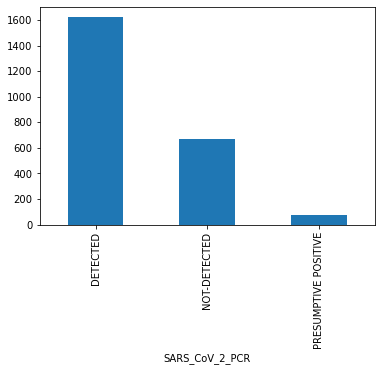

In [164]:
grouped_name = df4.groupby(['SARS_CoV_2_PCR'])['subject_accession'].count()
grouped_name.plot.bar()
plt.show()

<a id="16"></a>
## 7. Estimación de parámetros
[back to top](#0)

In [165]:
import sympy as sp

import scipy.integrate as scint
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import least_squares
sp.init_printing()

In [166]:
S,V, I, beta,gamma = sp.symbols('S V I beta gamma')

\begin{align}
 \frac{dS}{dt} &= S_{in} -k_{S}S(t)-\beta V(t)S(t)\\
 \frac{dI(t)}{dt} &= βV(t)S(t)-k_II(t)-γx(t)I(t)\\
 \frac{dV(t)}{dt} &= v_{in}I(t)-k_{V}V(t)\\
 \frac{dx(t)}{dt} &= x_{in}(1-\alpha E)-k_1x(t)+γ_1x(t)I(t)+b_1 \frac{x(t)}{c_1+x(t)}(x(t)-m)(y_1-y(t))(y(t)-y_2)\\
 \frac{dy(t)}{dt} &= y_{in}(1+\alpha E)-k_2y(t)+b_2 \frac{a_1y(t)x(t)}{a_2c_2+x(t)}
\end{align}

In [239]:
import math
import numpy
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def modulation(age):
    immune_modulation = max(0.1, 1 - 0.01 * age)  # Decreases with age, minimum 0.1
    cytokine_modulation = 1 + 0.01 * age  # Increases with age
    return immune_modulation, cytokine_modulation


# Definición de la función que representa el sistema de ecuaciones diferenciales
def f(U,b_2, age):
    immune_modulation, cytokine_modulation = modulation(age)
    # Cálculo de las derivadas de las cinco variables en el punto actual
    p1 = S_in - K_s * U[0] - beta * U[0] * U[2]
    p2 = beta * U[0] * U[2] - k_I * U[1] - gamma * U[3] * U[1]
    p3 = V_in * U[1] - K_v * U[2]
    z = U[3] / (c1 + U[3]) * (U[3] - m) * (y1 - U[4]) * (U[4] - y2)
    p4 = x_in * immune_modulation - k_1 * U[3] + gamma_1 * U[3] * U[1] + b_1 * z
    num = a_1 * U[4] * U[3]
    den = a_2 * (c2 + U[3])
    p5 = y_in * cytokine_modulation - k_2 * U[4] + b_2 * num / den
    # Devuelve un vector con las derivadas
    gg=np.array([p1,p2,p3,p4,p5])
    return gg

# Definición de la función que implementa el método de Runge-Kutta de cuarto orden
def RK4(U0,T,h,b_2, age): 
    # Bucle a través de todos los pasos de tiempo
    for i in range (0,T-1):
        # Cambio del valor de b_2 entre los tiempos 500 y 540
        if t[i]>=500 and t[i]<=540:
            b_2=0.88
        else:
            b_2=1
        # Cálculo de los coeficientes de Runge-Kutta
        k1 = f(U0, b_2, age)
        k2 = f(U0 + h * k1 / 2, b_2, age)
        k3 = f(U0 + h * k2 / 2, b_2, age)
        k4 = f(U0 + h * k3, b_2,age)
        # Actualización del vector de variables
        U0 = U0 + h / 6 * (k1 + 2 * (k2 + k3) + k4)
        # Almacenamiento de los resultados en los vectores correspondientes
        Sus[i] = U0[0]; Inf[i] = U0[1]; Vir[i] = U0[2];
        Im[i] = U0[3]; Cyt[i] = U0[4]
    # Devuelve los vectores de resultados
    return [Sus, Inf, Vir, Im, Cyt]

# Definición de parámetros y condiciones iniciales
S_in = 0.01     
K_s = 0.01      
beta = 0.1      
k_1 = 0.01      
k_I = 0.01      
gamma = 0.5     
gamma_1 = 0.05  
V_in = 0.1      
K_v = 0.1       
c1 = 1          
m = 0.1         
y1 = 1          
y2 = 3          
x_in = 7e-4     
b_1 = 1         
a_1 = 1
a_2 = 1
c2 = 1          
y_in = 0.018    
k_2 = 0.1       
b_2 = 1       
age = 60
U0 = np.array([1,0,0,0.07,0.18]) # Vector de condiciones iniciales

# Definición de parámetros de la simulación
tf = 1500; t0 = 0; T = 30000
h=(tf-t0)/(T-1); # Cálculo del tamaño del paso de tiempo
t=np.zeros(T);y=np.zeros(T);w=np.zeros(T);Urk=np.zeros(T)
Im=np.zeros(T); Cyt=np.zeros(T); Inf=np.zeros(T); Vir=np.zeros(T)
Sus=np.zeros(T)
t[0]=t0;

# Bucle a través de todos los pasos de tiempo
for i in range(1,T):
    t[i]=t[i-1]+h;


def cost_function(params, age, cytokine_data):
    # Desempaquetamos los parámetros
    S_in, K_s, beta, k_1, k_I, gamma, gamma_1, V_in, K_v, c1, m, y1, y2, x_in, b_1, a_1, a_2, c2, y_in, k_2, b_2, age = params

    # Resolvemos el sistema de ecuaciones diferenciales con estos parámetros
    [Sus, Inf, Vir, Im, Cyt] = RK4(U0, T, h, V_in, age)

    # Dividimos el tiempo total en segmentos que correspondan a los tiempos en los que se recogieron los datos de las citoquinas
    segment_length = len(Cyt) // len(cytokine_data)
    Cyt_segments = [Cyt[i:i+segment_length] for i in range(0, len(Cyt), segment_length)]

    # Tomamos la media de Cyt en esos segmentos
    Cyt_mean = np.array([np.mean(segment) for segment in Cyt_segments[:len(cytokine_data)]])

    # Calculamos la diferencia entre las predicciones del modelo y los datos clínicos
    cytokine_data_mean = np.mean(cytokine_data)
    cost = np.sum((Cyt_mean - cytokine_data_mean)**2)

    return cost


# Definimos los datos clínicos
age_n = df_val['Age']
cytokine_data = df_val['IL6','IL8','TNFA','IL1B']

# Definir los límites para cada uno de los parámetros
bounds = [(0, 100)]*len(initial_params)

# Definimos los parámetros iniciales
initial_params = np.array([S_in, K_s, beta, k_1, k_I, gamma, gamma_1, V_in, K_v, c1, m, y1, y2, x_in, b_1, a_1, a_2, c2, y_in, k_2, b_2, age])

# Usamos un algoritmo de optimización para encontrar los parámetros que minimizan la función de costo
result = minimize(cost_function, initial_params, args=(age_n, cytokine_data),bounds=bounds, method='L-BFGS-B')

# Imprimimos los parámetros óptimos
print(result.x)

[1.00000000e-02 1.00000000e-02 1.00000000e-01 9.65669555e-03
 1.00000000e-02 5.00000000e-01 5.00000001e-02 1.00000000e-01
 1.00000000e-01 9.99979041e-01 1.00745960e-01 1.00002725e+00
 3.00000794e+00 2.66394092e-03 1.00002242e+00 1.00045995e+00
 9.99540236e-01 9.99570794e-01 6.43627705e-02 9.30725496e-02
 1.00045995e+00 5.99999947e+01 1.00000000e+00 1.71651834e-05
 0.00000000e+00 7.55379091e-02 9.97621232e-02]


<a id="17"></a>
## 8. Validación cruzada: Modelo de predicción
[back to top](#0)

In [175]:
df_detected_cyt['MAX_SEVERITY'] = df_detected_cyt['MAX_SEVERITY'].astype('float64')

In [192]:
df_detected_cyt.dropna(subset=['IL8','IL1B'], inplace= True )


In [193]:
df_val = df_detected_cyt[df_detected_cyt['MAX_SEVERITY'] != 2.00]

In [194]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 953 entries, 0 to 1256
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subject_accession     953 non-null    object 
 1   gender                953 non-null    object 
 2   Age                   953 non-null    float64
 3   study_time_collected  953 non-null    float64
 4   name                  953 non-null    object 
 5   IL6                   953 non-null    float64
 6   IL8                   953 non-null    float64
 7   TNFA                  953 non-null    float64
 8   IL1B                  953 non-null    float64
 9   DECEASED              953 non-null    object 
 10  DISEASE_SEVERITY      896 non-null    object 
 11  SEVERITY              760 non-null    object 
 12  SEVERITY_NUMERIC      886 non-null    object 
 13  MAX_SEVERITY          953 non-null    float64
 14  SARS_CoV_2_PCR        953 non-null    object 
 15  IL6_flag              

              precision    recall  f1-score   support

         1.0       0.71      0.76      0.74       138
         3.0       0.74      0.69      0.72       137

    accuracy                           0.73       275
   macro avg       0.73      0.73      0.73       275
weighted avg       0.73      0.73      0.73       275



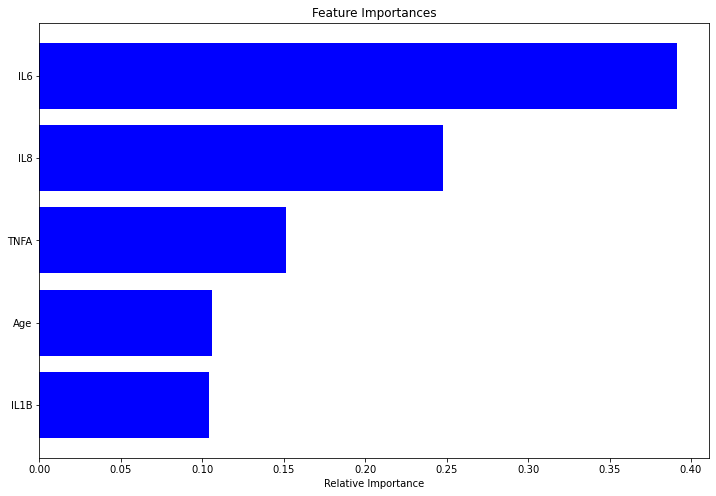

In [215]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np


# Asegurarse de que las columnas estan presentes

# Definir las variables de entrada y salida
features = ["Age", "IL6", "IL8", "TNFA", "IL1B"]
X = df_val[features]
y = df_val["MAX_SEVERITY"]

# Normalizar los datos
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Balanceo de clases utilizando SMOTE
smote = SMOTE()
X, y = smote.fit_resample(X, y)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Crear el modelo
modelo = RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=500, random_state=42)

# Entrenar el modelo
modelo.fit(X_train, y_train)

# Realizar las predicciones
y_pred_test = modelo.predict(X_test)

# Imprimir el informe de clasificación
print(classification_report(y_true=y_test, y_pred=y_pred_test))

# Mostrar la importancia de cada característica
importances = modelo.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [216]:
clf_vals = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
model_val,predictions_val = clf_vals.fit(X_train, X_test, y_train, y_test)
print(model_val)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 21.68it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
RandomForestClassifier             0.75               0.75     0.75      0.75   
ExtraTreesClassifier               0.74               0.74     0.74      0.74   
LGBMClassifier                     0.72               0.72     0.72      0.72   
AdaBoostClassifier                 0.72               0.72     0.72      0.72   
ExtraTreeClassifier                0.70               0.70     0.70      0.70   
Perceptron                         0.68               0.68     0.68      0.68   
NuSVC                              0.68               0.68     0.68      0.67   
BaggingClassifier                  0.67               0.67     0.67      0.67   
LogisticRegression                 0.67               0.67     0.67      0.66   
SGDClassifier                      0.66               0.66     0.66      0.65   
LinearSVC                   

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90],
    'min_samples_split': [1, 2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Ajustar el grid search a los datos
grid_search.fit(X_train, y_train)
best_clf = grid_search.best_estimator_
print("Mejor clasificador:\n", best_clf)
print("Mejor puntuación:\n", grid_search.best_score_)

In [197]:
#pip install imbalanced-learn

In [198]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Aplicar una transformación a las columnas
data_val_transformed = df_val.copy()
data_val_transformed['IL6'] = df_val['IL6']**2
data_val_transformed['IL8'] = df_val['IL8']**1.8
data_val_transformed['TNFA'] = df_val['TNFA']**1.6
data_val_transformed['Age'] = df_val['Age']**1.4
data_val_transformed['IL1B'] = df_val['IL1B']**1.2

# Separar las variables dependientes e independientes
X = data_val_transformed[['Age', 'IL6', 'IL8', 'TNFA', 'IL1B']]
y = data_val_transformed['MAX_SEVERITY']

# Normalizar los datos
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Balanceo de clases utilizando SMOTE
smote = SMOTE()
X, y = smote.fit_resample(X, y)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Definir el modelo y los parámetros para la búsqueda de cuadrícula
# Entrenar el modelo
clf = RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=500, random_state=42)
clf.fit(X_train, y_train)

# Hacer las predicciones
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

# Imprimir los informes de clasificación
print("Reporte de clasificación - Conjunto de entrenamiento")
print(classification_report(y_train, y_pred_train))
print("\nReporte de clasificación - Conjunto de prueba")
print(classification_report(y_test, y_pred_test))

Reporte de clasificación - Conjunto de entrenamiento
              precision    recall  f1-score   support

         1.0       0.95      0.99      0.97       411
         3.0       0.98      0.95      0.97       412

    accuracy                           0.97       823
   macro avg       0.97      0.97      0.97       823
weighted avg       0.97      0.97      0.97       823


Reporte de clasificación - Conjunto de prueba
              precision    recall  f1-score   support

         1.0       0.74      0.78      0.76       138
         3.0       0.77      0.73      0.75       137

    accuracy                           0.76       275
   macro avg       0.76      0.76      0.76       275
weighted avg       0.76      0.76      0.76       275



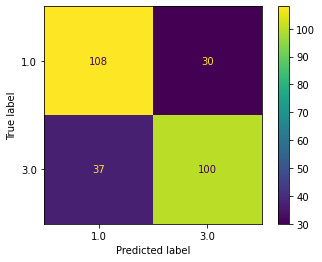

In [199]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_test, y_test)